<a href="https://colab.research.google.com/github/Kaunaz/Assets/blob/master/main_notebook_tom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/danieldamc/dataton-usm-2024/blob/main/test_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import plotly.graph_objs as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2 as transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# try:
#     import lenstools
# except:
#     print("[INFO] Couldn't find lenstools... installing it.")
#     !pip install -q lenstools
#     import lenstools

[INFO] Couldn't find torchinfo... installing it.


In [2]:
MODELS_PATH = 'models'
Path(MODELS_PATH).mkdir(parents=True, exist_ok=True)
RANDOM_SEED = 1
EPOCHS = 50
BATCH_SIZE = 64
MODEL_NAME = 'encoder_decoder_CNN'
CHECKPOINT_STEP = 5
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

DEBUG = False

In [3]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

if DEBUG:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset

Small dataset: 1Fiqy5bkIp1HD8NKjiQaME-2QSFzO7lDF  
1: 1gbShLIyAdS2hYrSVWsNrhekL1PgqxWA2

In [4]:
data_zip = 'small_dataset.tar.gz'

if Path(data_zip).is_file():
    print("File already exists.")
else:
    import gdown

    file_id = '1Fiqy5bkIp1HD8NKjiQaME-2QSFzO7lDF'
    url = f'https://drive.google.com/uc?id={file_id}'

    gdown.download(url, data_zip, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Fiqy5bkIp1HD8NKjiQaME-2QSFzO7lDF
From (redirected): https://drive.google.com/uc?id=1Fiqy5bkIp1HD8NKjiQaME-2QSFzO7lDF&confirm=t&uuid=3eb1ee83-9b60-4b13-9d25-04c5acdae3ea
To: /content/small_dataset.tar.gz
100%|██████████| 798M/798M [00:14<00:00, 55.9MB/s]


In [5]:
!tar -xf small_dataset.tar.gz

In [6]:
epsilon_filepath = 'small_dataset/EPSILON/00001_00001.npy'
kappa_filepath = 'small_dataset/KAPPA/00001_00001.npy'

In [7]:
epsilon_data = np.load(epsilon_filepath)
kappa_data = np.load(kappa_filepath)
epsilon_data.shape, kappa_data.shape

((3, 128, 128), (128, 128))

In [8]:
class LensingDataset(Dataset):
    def __init__(self, root_dir, transform=None, transform_test=None):
        self.root_dir = root_dir
        self.transform = transform
        self.epsilon_dir = os.path.join(root_dir, 'EPSILON')
        self.kappa_dir = os.path.join(root_dir, 'KAPPA')

        self.epsilon_files = os.listdir(self.epsilon_dir)
        self.kappa_files = os.listdir(self.kappa_dir)

        self.epsilon_files.sort()
        self.kappa_files.sort()

    def __len__(self):
        return len(os.listdir(self.epsilon_dir))


    def __getitem__(self, idx):
        epsilon_image_path = os.path.join(self.epsilon_dir, self.epsilon_files[idx])
        kappa_image_path = os.path.join(self.kappa_dir, self.kappa_files[idx])

        epsilon_image = np.load(epsilon_image_path)
        kappa_image = np.load(kappa_image_path)

        kappa_image = np.expand_dims(kappa_image, axis=0)

        epsilon_image = torch.from_numpy(epsilon_image).float()
        kappa_image = torch.from_numpy(kappa_image).float()

        if self.transform:
            epsilon_image = self.transform(epsilon_image)

        return epsilon_image, kappa_image

In [9]:
class BaselineAugmentation:
    def __init__(self):
        self.rotations = [0, 90, 180, 270]

    def __call__(self, x):
        angle = random.choice(self.rotations)
        x = transforms.functional.rotate(x, angle)

        if random.random() > 0.5:
            x = transforms.functional.hflip(x)
        if random.random() > 0.5:
            x = transforms.functional.vflip(x)
        return x

class ToTensor(object):
    def __init__(self):
        pass

    def __call__(self, x):
        return torch.from_numpy(x).float()

## Dataset loader

In [10]:
dataset_means, dataset_stds = [7.0964e-06, -1.8894e-05, -2.7692e-05], [0.1863, 0.1860, 0.1838]
dataset_means, dataset_stds = torch.tensor(dataset_means), torch.tensor(dataset_stds)

In [11]:
transform = transforms.Compose([
    transforms.Normalize(mean=dataset_means, std= dataset_stds)
])


lensing_dataset = LensingDataset(root_dir='small_dataset', transform=transform)

torch.manual_seed(RANDOM_SEED)
train_set, val_set, test_set = random_split(lensing_dataset, [0.75, 0.2, 0.05])

train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          generator=torch.Generator().manual_seed(RANDOM_SEED))
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

In [12]:
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0
    for images, _ in loader:
        images_count_in_batch = images.size(0)
        images = images.view(images_count_in_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += images_count_in_batch

    mean /= total_images_count
    std /= total_images_count
    return mean, std

In [13]:
def compare_kappa(y_true, y_pred):
    plt.hist(y_true.flatten(), bins=100, alpha=0.6, label='True', color='blue', range=[-0.5, 0.5])
    plt.hist(y_pred.flatten(), bins=100, alpha=0.6, label='Pred', color='orange', range=[-0.5, 0.5])
    plt.legend(loc='upper right')
    plt.title('Histograma de Kappa')
    plt.xlabel('Kappa Value')
    plt.ylabel('Frequency')
    plt.show()

In [28]:
x, y= next(iter(train_loader))
x,y = x[0], y[0]
x.shape, y.shape

(torch.Size([3, 128, 128]), torch.Size([1, 128, 128]))

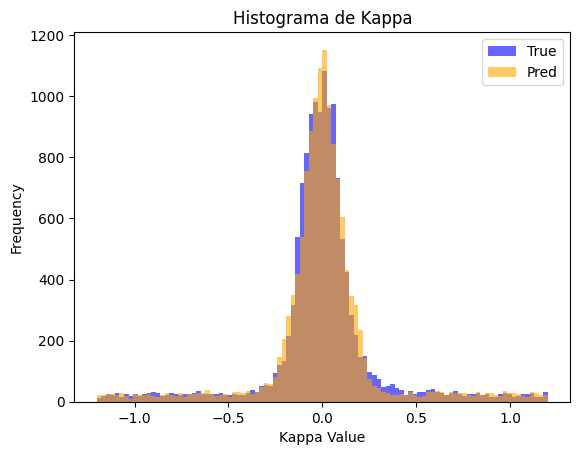

In [31]:
def compare_kappa(y_true, y_pred):
    plt.hist(y_true.flatten(), bins=100, alpha=0.6, label='True', color='blue', range=[-1.2, 1.2])
    plt.hist(y_pred.flatten(), bins=100, alpha=0.6, label='Pred', color='orange', range=[-1.2, 1.2])
    plt.legend(loc='upper right')
    plt.title('Histograma de Kappa')
    plt.xlabel('Kappa Value')
    plt.ylabel('Frequency')
    plt.show()

compare_kappa(x[0], x[1])

In [123]:
unique_values, counts = torch.unique(x[0], return_counts=True)
sorted_indices = torch.argsort(counts, descending=True)
first_mode = unique_values[sorted_indices[0]].item()
second_mode = unique_values[sorted_indices[1]].item()
print(f"Mode: {first_mode}, count: [{counts[0]}]")
print(f"second Mode: {second_mode}, count: [{counts[1]}]")

tensor([1, 1, 1,  ..., 1, 1, 1])
Mode: 0.00015064323088154197, count: [1]
second Mode: -0.17139561474323273, count: [1]


In [13]:
def plot_record(epsilon, kappa, show_axis=False, cmap=None):
    if show_axis:
        axis = 'on'
    else:
        axis = 'off'

    epsilon_vmin = np.min(epsilon)
    epsilon_vmax = np.max(epsilon)

    kappa_vmin = np.min(kappa)
    kappa_vmax = np.max(kappa)

    plt.figure(figsize=(12, 7))

    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.subplot(1, 4, 1)
    plt.imshow(epsilon[0], vmin=epsilon_vmin, vmax=epsilon_vmax, cmap=cmap)
    plt.title('Epsilon 1')
    plt.axis(axis)

    plt.subplot(1, 4, 2)
    plt.imshow(epsilon[1], vmin=epsilon_vmin, vmax=epsilon_vmax, cmap=cmap)
    plt.title('Epsilon 2')
    plt.axis(axis)

    plt.subplot(1, 4, 3)
    plt.imshow(epsilon[2], vmin=epsilon_vmin, vmax=epsilon_vmax, cmap=cmap)
    plt.title('Delta Epsilon')
    plt.axis(axis)

    plt.subplot(1, 4, 4)
    plt.imshow(kappa, vmin=kappa_vmin, vmax=kappa_vmax, cmap=cmap)
    plt.title('Kappa')
    plt.axis(axis)

    plt.show()

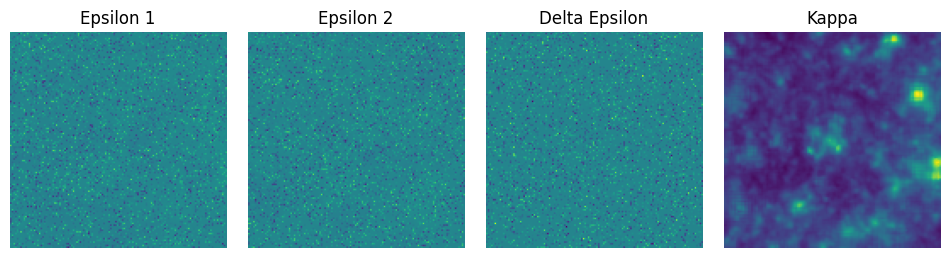

In [14]:
plot_record(epsilon_data, kappa_data, show_axis=False)

In [15]:
def plot_kappa(kappa_true, kappa_pred, show_axis=False, show_dpeaks= False, cmap=None):
    kt= kappa_true.astype(np.float32)
    kp= kappa_pred.astype(np.float32)
    if show_axis:
        axis = 'on'
        plt.figure(figsize=(7, 3))
    else:
        axis = 'off'
        plt.figure(figsize=(6, 3))

    if show_dpeaks:
        dpeaks_true, _ = find_n_max_peaks(kt, n=3)
        dpeaks_pred, _ = find_n_max_peaks(kp, n=3)

    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.subplot(1, 2, 1)
    plt.imshow(kt, cmap=cmap)
    plt.title('Kappa True')
    if show_dpeaks:
        plt.scatter(dpeaks_true[:, 1], dpeaks_true[:, 0], color='red')
    plt.axis(axis)

    plt.subplot(1, 2, 2)
    plt.imshow(kp, cmap=cmap)
    plt.title('Kappa Prediction')
    if show_dpeaks:
        plt.scatter(dpeaks_pred[:, 1], dpeaks_pred[:, 0], color='red')
    plt.axis(axis)

    plt.show()

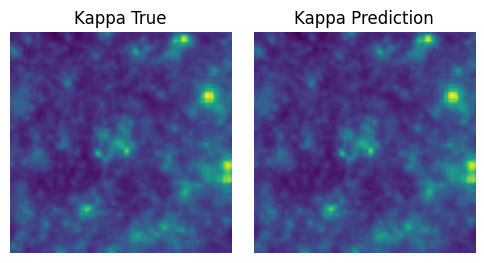

In [16]:
plot_kappa(kappa_data, kappa_data)

# DPeaks Testing

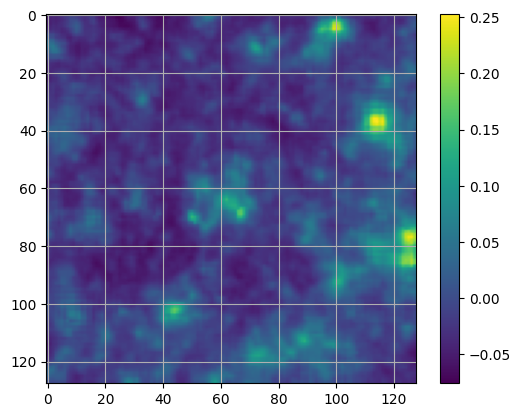

(128, 128)
0.2532 -0.07587


In [17]:
cm = np.load(kappa_filepath)

# plot cm
plt.imshow(cm)
plt.colorbar()
plt.grid()
plt.show()

print(cm.shape)
print(cm.max(), cm.min())

In [18]:
import numpy as np
from scipy.ndimage import maximum_filter, label, find_objects

def find_peaks(data, threshold=None, neighborhood_size=3):
    # Apply a maximum filter to find local maxima
    data_max = maximum_filter(data, neighborhood_size)

    # Create a boolean mask where the data is equal to the local maximum
    maxima = (data == data_max)

    if threshold is not None:
        # Apply the threshold
        maxima[data > threshold] = False

    # Label the maxima
    labeled, num_objects = label(maxima)

    # Get the coordinates of the maxima
    slices = find_objects(labeled)
    coordinates = []
    for dy, dx in slices:
        x_center = (dx.start + dx.stop - 1) // 2
        y_center = (dy.start + dy.stop - 1) // 2
        coordinates.append((x_center, y_center))

    return np.array(coordinates)

def find_n_max_peaks(data, n=10, threshold=None, neighborhood_size=3, verbose=False):
    # Find the peaks
    peaks = find_peaks(data, threshold, neighborhood_size)

    peaks2 = []

    for x, y in peaks:
        intensity = data[x, y]
        if verbose: print(f"Peak at ({x}, {y}) with intensity {intensity}")

        peaks2.append((x, y, intensity))

    # Sort the peaks by intensity in descending order
    peaks2.sort(key=lambda x: x[2], reverse=True)

    coords = [(x, y) for x, y, _ in peaks2]
    intensities = [intensity for _, _, intensity in peaks2]

    # Return the top n peaks
    return np.array(coords[:n]), np.array(intensities[:n])

In [19]:
# change dtype of numpy array
cm_ = cm.astype(np.float32)

peaks = find_peaks(cm_, threshold=0.2)

In [20]:
coords, intensities = find_n_max_peaks(cm_, n=3, threshold=0.2)
print(coords)
print(intensities)

[[ 38 114]
 [  5 101]
 [ 76 127]]
[0.24194336 0.20922852 0.2043457 ]


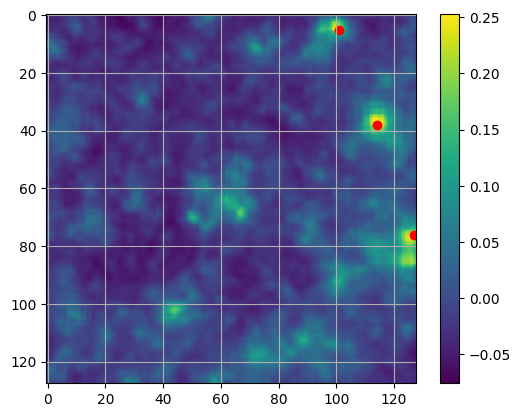

In [21]:
X = coords[:, 1]
Y = coords[:, 0]

plt.imshow(cm)
plt.colorbar()
plt.scatter(X, Y, color='red')
plt.grid()
plt.show()

# Loss

In [22]:
class WeightedMSELoss(nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, y_pred, y_true):
        max_val = torch.max(y_true)
        weights = 1 + (torch.abs(y_true) / max_val)

        loss = weights * (y_pred - y_true) ** 2
        return torch.sum(loss)

# Metrics

## WMAPE

In [23]:
def wmape_np(y_true : np.ndarray, y_pred : np.ndarray):
    W = 1 + (y_true / np.max(y_true))
    return np.sum(W * (np.abs(y_pred - y_true) / np.abs(y_true)) / np.sum(W))

def wmape(y_true : torch.Tensor, y_pred : torch.Tensor):
    W = 1 + (y_true / torch.max(y_true))

    y_true = torch.where(y_true == 0, torch.tensor(1e-7), y_true)
    randderecha = torch.abs(y_pred - y_true) / torch.abs(y_true)
    num = torch.sum(W * randderecha)

    denom = torch.sum(W)
    return (num / denom).item()

wmape_np(kappa_data, kappa_data), wmape(torch.from_numpy(kappa_data), torch.from_numpy(kappa_data))

wmape_np(kappa_data, kappa_data), wmape(torch.from_numpy(kappa_data), torch.from_numpy(kappa_data))

(0.0, 0.0)

## DICEE

In [24]:
def dicee_np(y_true : np.ndarray, y_pred : np.ndarray, alpha=0.5, beta=0.5):
    G = y_true > np.average(y_true)
    A = y_pred > np.average(y_pred)

    return 1 - np.sum(G * A) / (np.sum(G * A) + alpha * np.sum((1 - G) * A) + beta * np.sum((1 - A) * G))

def dicee(y_true : torch.Tensor, y_pred : torch.Tensor, alpha=0.5, beta=0.5):
    G = (y_true > torch.mean(y_true)).int()
    A = (y_pred > torch.mean(y_pred)).int()

    return (1 - torch.sum(G * A) / (torch.sum(G * A) + alpha * torch.sum((1 - G) * A) + beta * torch.sum((1 - A) * G))).item()

dicee_np(kappa_data, kappa_data), dicee(torch.from_numpy(kappa_data), torch.from_numpy(kappa_data))

(0.0, 0.0)

## DPeaks

In [25]:
import numpy as np
from scipy.ndimage import maximum_filter, label, find_objects

def find_peaks(data, threshold=None, neighborhood_size=3):
    # Apply a maximum filter to find local maxima
    data_max = maximum_filter(data, neighborhood_size)

    # Create a boolean mask where the data is equal to the local maximum
    maxima = (data == data_max)

    if threshold is not None:
        # Apply the threshold
        maxima[data > threshold] = False

    # Label the maxima
    labeled, num_objects = label(maxima)

    # Get the coordinates of the maxima
    slices = find_objects(labeled)
    coordinates = []
    for dy, dx in slices:
        x_center = (dx.start + dx.stop - 1) // 2
        y_center = (dy.start + dy.stop - 1) // 2
        coordinates.append((x_center, y_center))

    return np.array(coordinates)

def find_n_max_peaks(data, n=10, threshold=None, neighborhood_size=3, verbose=False):
    # Find the peaks
    peaks = find_peaks(data, threshold, neighborhood_size)

    peaks2 = []

    for x, y in peaks:
        intensity = data[x, y]
        if verbose: print(f"Peak at ({x}, {y}) with intensity {intensity}")

        peaks2.append((x, y, intensity))

    # Sort the peaks by intensity in descending order
    peaks2.sort(key=lambda x: x[2], reverse=True)

    coords = [(x, y) for x, y, _ in peaks2]
    intensities = [intensity for _, _, intensity in peaks2]

    # Return the top n peaks
    return np.array(coords[:n]), np.array(intensities[:n])

def dpeaks_np(y_true : np.ndarray, y_pred : np.ndarray, n=3):
    true_peaks_coord, _ = find_n_max_peaks(y_true.astype(np.float32), n=n)
    pred_peaks_coord, _ = find_n_max_peaks(y_pred.astype(np.float32), n=n)

    X_true = true_peaks_coord[:, 1]
    Y_true = true_peaks_coord[:, 0]

    X_pred = pred_peaks_coord[:, 1]
    Y_pred = pred_peaks_coord[:, 0]

    return np.sum(np.abs(X_true - X_pred) + np.abs(Y_true - Y_pred))


def dpeaks(y_true : torch.Tensor, y_pred : torch.Tensor, n=3):
    y_true_np = y_true.cpu().numpy().astype(np.float32)
    y_pred_np = y_pred.cpu().numpy().astype(np.float32)

    #[64, 1, 128, 128]

    dpeaks_sum = 0

    for i in range(y_true_np.shape[0]):
        y_true_im = y_true_np[i].squeeze()
        y_pred_im = y_pred_np[i].squeeze()

        dpeaks_im = dpeaks_np(y_true_im, y_pred_im, n=n)
        dpeaks_sum += dpeaks_im

    return dpeaks_sum / y_true_np.shape[0]

    return

dpeaks_np(kappa_data, kappa_data), dpeaks(torch.from_numpy(kappa_data).unsqueeze(0), torch.from_numpy(kappa_data).unsqueeze(0))

(0, 0.0)

# Training functions

In [26]:
def save_checkpoint(model, optimizer, epoch, history, filepath='checkpoint.pth'):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'history': history,
        'random_state': {
            'python': random.getstate(),
            'numpy': np.random.get_state(),
            'torch': torch.get_rng_state(),
            'torch_cuda': torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
        }
    }
    torch.save(checkpoint, filepath)
    print(f'Checkpoint saved to {filepath}\n')

In [27]:
def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    checkpoint = torch.load(filename, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    history = checkpoint['history']

    random.setstate(checkpoint['random_state']['python'])
    np.random.set_state(checkpoint['random_state']['numpy'])
    torch.set_rng_state(checkpoint['random_state']['torch'])
    if torch.cuda.is_available() and checkpoint['random_state']['torch_cuda'] is not None:
        torch.cuda.set_rng_state_all(checkpoint['random_state']['torch_cuda'])

    return epoch, history

In [28]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, start_epoch=None, metrics=None, device='cuda'):

    history = {
        'train_losses': [],
        'val_losses': [],
        }

    if metrics is not None:
        for metric_name in metrics.keys():
            history[f'train_{metric_name}'] = []
            history[f'val_{metric_name}'] = []

    if start_epoch is None:
        start_epoch = 1

    if start_epoch > epochs:
        raise ValueError("start_epoch must be less than or equal to epochs")

    for epoch in range(start_epoch, epochs + 1):
        model.train()

        train_p_bar = tqdm(enumerate(train_loader), total=len(train_loader))

        epoch_train_loss = 0
        epoch_val_loss = 0

        epoch_train_metrics = {metric_name: 0 for metric_name in metrics.keys()}
        epoch_val_metrics = {metric_name: 0 for metric_name in metrics.keys()}


        for _, (epsilon, kappa) in train_p_bar:
            epsilon, kappa = epsilon.to(device), kappa.to(device)

            optimizer.zero_grad()

            y_hat = model(epsilon)
            loss = criterion(y_hat, kappa)
            loss.backward()
            optimizer.step()

            batch_size = epsilon.size(0)

            epoch_train_loss += loss.item() * batch_size

            kappa_detached = kappa.detach()
            y_hat_detached = y_hat.detach()

            for metric_name, metric_fn in metrics.items():
                metric_value = metric_fn(kappa_detached, y_hat_detached)
                epoch_train_metrics[metric_name] += metric_value * batch_size

            train_p_bar.set_description(f"Epoch: {epoch}/{epochs}, Loss: {loss.item():.4f}")


        epoch_train_loss /= len(train_loader.dataset)
        history['train_losses'].append(epoch_train_loss)


        for metric_name in metrics.keys():
            epoch_train_metrics[metric_name] /= len(train_loader.dataset)
            history[f'train_{metric_name}'].append(epoch_train_metrics[metric_name])

        train_metrics_formatted = ', '.join([f"{metric_name}: {epoch_train_metrics[metric_name]:.4f}" for metric_name in metrics.keys()])
        print(f"Train Metrics: Loss: {epoch_train_loss:.4f}, {train_metrics_formatted}")

        model.eval()
        with torch.inference_mode():
            val_p_bar = tqdm(enumerate(val_loader), total=len(val_loader))
            for _, (epsilon, kappa) in val_p_bar:
                epsilon, kappa = epsilon.to(device), kappa.to(device)
                y_hat = model(epsilon)
                loss = criterion(y_hat, kappa)

                batch_size = epsilon.size(0)

                epoch_val_loss += loss.item() * batch_size

                kappa_detached = kappa.detach()
                y_hat_detached = y_hat.detach()

                for metric_name, metric_fn in metrics.items():
                    metric_value = metric_fn(kappa_detached, y_hat_detached)
                    epoch_val_metrics[metric_name] += metric_value * batch_size

                val_p_bar.set_description(f"Epoch: {epoch}/{epochs}, Loss: {loss.item():.4f}")

        epoch_val_loss /= len(val_loader.dataset)
        history['val_losses'].append(epoch_val_loss)

        for metric_name in metrics.keys():
            epoch_val_metrics[metric_name] /= len(val_loader.dataset)
            history[f'val_{metric_name}'].append(epoch_val_metrics[metric_name])

        val_metrics_formatted = ', '.join([f"{metric_name}: {epoch_val_metrics[metric_name]:.4f}" for metric_name in metrics.keys()])
        print(f"Val Metrics: Loss: {epoch_val_loss:.4f}, {val_metrics_formatted}")

        #save model
        if epoch % CHECKPOINT_STEP == 0:
            save_checkpoint(model, optimizer, epoch, history, os.path.join(MODELS_PATH, f'{MODEL_NAME}_model_{epoch}E.pth'))
        else:
            print('\n')
    return history


In [29]:
def evaluate(model: nn.Module,
             test_loader: torch.utils.data.DataLoader,
             criterion: torch.nn.Module,
             epoch: int,
             epochs: int,
             metrics: dict,
             device: torch.device):

    metrics = {metric_name: 0 for metric_name in metrics.keys()}
    total_loss = 0

    model.eval()
    with torch.inference_mode():
        p_bar = tqdm(enumerate(test_loader), total=len(test_loader))
        for _, (epsilon, kappa) in p_bar:
            epsilon, kappa = epsilon.to(device), kappa.to(device)
            y_hat = model(epsilon)
            loss = criterion(y_hat, kappa)

            batch_size = epsilon.size(0)

            total_loss += loss.item() * batch_size

            kappa_detached = kappa.detach()
            y_hat_detached = y_hat.detach()

            for metric_name, metric_fn in metrics.items():
                metric_value = metric_fn(kappa_detached, y_hat_detached)
                metrics[metric_name] += metric_value * batch_size

            p_bar.set_description(f"Epoch: {epoch}/{epochs}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(test_loader.dataset)
    metrics_formatted = ', '.join([f"{metric_name}: {metrics[metric_name]:.4f}" for metric_name in metrics.keys()])
    print(f"Evaluation Metrics: Loss: {avg_loss:.4f}, {metrics_formatted}")

    return avg_loss, metrics

# Dataset Exploring

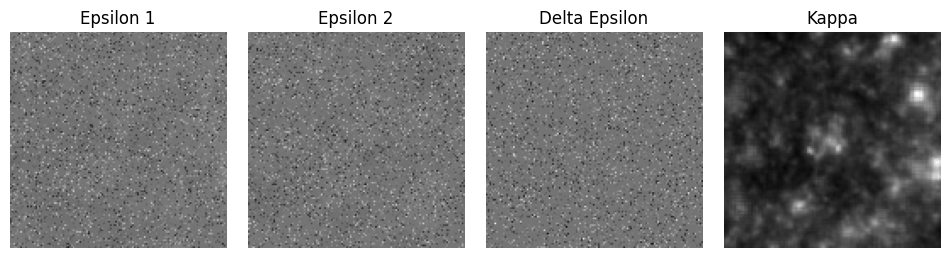

In [ ]:
PATH = 'small_dataset'

epsilon = np.load(os.path.join(PATH, 'EPSILON', '00001_00001.npy'))
kappa = np.load(os.path.join(PATH, 'KAPPA', '00001_00001.npy'))

plot_record(epsilon, kappa, show_axis=False, cmap='gray')

In [ ]:
kappa.shape

(128, 128)

[[ 38 114]
 [  5 101]
 [ 76 127]]


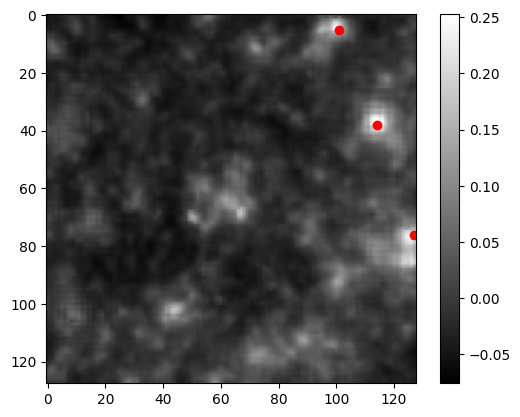

In [ ]:
kappa = kappa.astype(np.float32)

coords, _ = find_n_max_peaks(kappa, n=3)
print(coords)

plt.imshow(kappa, cmap='gray')
plt.colorbar()
plt.scatter(coords[:, 1], coords[:, 0], color='red')
plt.show()

In [ ]:
kappa.shape

(128, 128)

In [ ]:
def crop_image(epsilon, kappa, center_coord, size=5):
    # Get the height and width of the image
    height, width = kappa.shape

    center_y, center_x  = center_coord

    half_crop_size = size//2
    top_left_x = max(0, center_x - half_crop_size)
    top_left_y = max(0, center_y - half_crop_size)
    bottom_right_x = min(width, center_x + half_crop_size + 1)
    bottom_right_y = min(height, center_y + half_crop_size + 1)

    cropped_kappa = kappa[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
    cropped_epsilon = epsilon[:, top_left_y:bottom_right_y, top_left_x:bottom_right_x]

    return cropped_epsilon, cropped_kappa

(3, 51, 39) (51, 39)


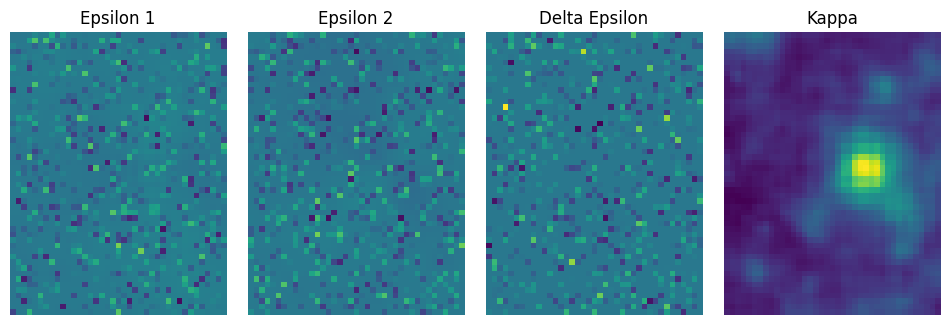

In [ ]:
epsilon_cropped, kappa_cropped = crop_image(epsilon, kappa, coords[0], size=50)
print(epsilon_cropped.shape, kappa_cropped.shape)
plot_record(epsilon_cropped, kappa_cropped, show_axis=False)

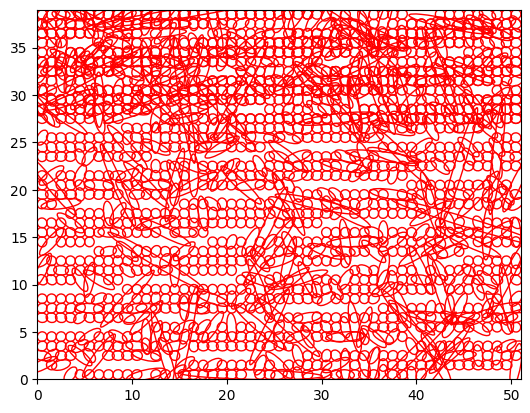

In [ ]:
import matplotlib.patches as patches


epsilon_1, epsilon_2 = epsilon_cropped[0], epsilon_cropped[1]
step = 1

x, y = step/2, step/2

fig, ax = plt.subplots()
ax.set_xlim(0, epsilon_1.shape[0] * step)
ax.set_ylim(0, epsilon_1.shape[1] * step)

def convert_coords(x, y, height):
    return x, height - y

height = ax.get_ylim()[1]

for i in range(epsilon_1.shape[0]):
    for j in range(epsilon_1.shape[1]):
        epsilon_1_val = epsilon_1[i, j]
        epsilon_2_val = epsilon_2[i, j]

        phi = 0.5 * np.arctan2(epsilon_2_val, epsilon_1_val) * 180 / np.pi
        e = np.sqrt(epsilon_1_val**2 + epsilon_2_val**2)
        a = (1 + e) / (1 - e)
        b = 1 #(1 - e) / (1 + e)
        # angle = 0

        # Create an ellipse
        #ellipse = patches.Ellipse(convert_coords(x, y, height), width=2*epsilon_1_val, height=2*epsilon_2_val, angle=angle, edgecolor='r', facecolor='none')
        ellipse = patches.Ellipse(convert_coords(x, y, height), width=a, height=b, angle=phi, edgecolor='r', facecolor='none')
        #ellipse = patches.Ellipse((x, y), width=1, height=1, angle=angle, edgecolor='r', facecolor='none')

        ax.add_patch(ellipse)
        x += step
        x = x % (epsilon_1.shape[0] * step)
    y += step
    y = y % (epsilon_1.shape[1] * step)

ax.set_aspect('equal')
plt.show()

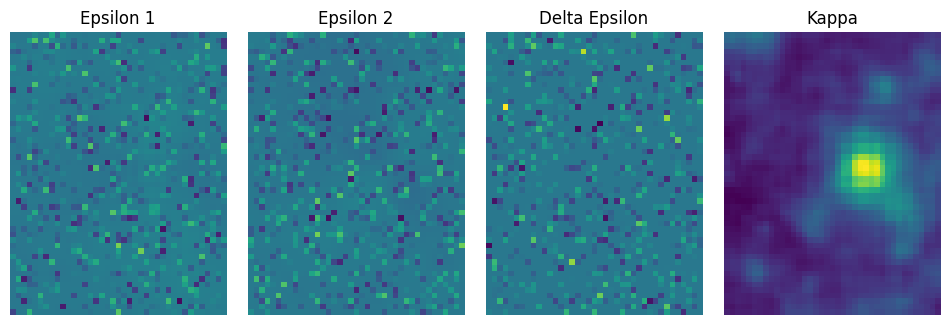

In [ ]:
plot_record(epsilon_cropped, kappa_cropped, show_axis=False)

# First Try Reference paper NET

## Model

In [ ]:
# TODO: remove Hardcode
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvBlock, self).__init__()
        self.trans_conv2d = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        self.conv2d = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size)
        self.bn = nn.BatchNorm2d(out_channels)

        self.tanh = nn.Tanh()

    def forward(self, x, multiply_input):
        x = self.tanh(self.trans_conv2d(x))
        x = self.tanh(self.conv2d(x))
        x = self.bn(x * multiply_input)
        return x


class ConvNet(nn.Module):
    def __init__(self, channel1: int = 32, channel2: int = 64, kernel_size=49):
        super(ConvNet, self).__init__()
        self.conv2d_1 = nn.Conv2d(in_channels=3, out_channels=channel1, kernel_size=3, padding=1)
        #self.avg_pool = nn.AvgPool2d(kernel_size=1) # kernel_size=3

        self.block1 = ConvBlock(in_channels=channel1, out_channels=channel1, kernel_size=kernel_size)
        self.block2 = ConvBlock(in_channels=channel1, out_channels=channel1, kernel_size=kernel_size)
        self.block3 = ConvBlock(in_channels=channel1, out_channels=channel1, kernel_size=kernel_size)
        self.block4 = ConvBlock(in_channels=channel1, out_channels=channel1, kernel_size=kernel_size)

        self.trans_conv2d_5 = nn.ConvTranspose2d(in_channels=channel1, out_channels=channel2, kernel_size=kernel_size)
        self.out_conv = nn.Conv2d(in_channels=channel2, out_channels=1, kernel_size=kernel_size)

        self.tanh = nn.Tanh()

    def forward(self, x):
        #x = self.avg_pool(F.tanh(self.conv2d_1(x)))
        x = self.tanh(self.conv2d_1(x))
        avg_pool = x.clone()

        x = self.block1(x, avg_pool)
        multiply_1 = x.clone()

        x = self.block2(x, multiply_1)
        multiply_2 = x.clone()

        x = self.block3(x, multiply_2)

        x = self.block4(x, multiply_1)

        x = self.tanh(self.trans_conv2d_5(x))

        x = self.out_conv(x)
        return x

In [ ]:
model = ConvNet(channel1=8, channel2=16, kernel_size=27)
summary(model, input_size=(32, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [32, 1, 128, 128]         --
├─Conv2d: 1-1                            [32, 8, 128, 128]         224
├─Tanh: 1-2                              [32, 8, 128, 128]         --
├─ConvBlock: 1-3                         [32, 8, 128, 128]         --
│    └─ConvTranspose2d: 2-1              [32, 8, 154, 154]         46,664
│    └─Tanh: 2-2                         [32, 8, 154, 154]         --
│    └─Conv2d: 2-3                       [32, 8, 128, 128]         46,664
│    └─Tanh: 2-4                         [32, 8, 128, 128]         --
│    └─BatchNorm2d: 2-5                  [32, 8, 128, 128]         16
├─ConvBlock: 1-4                         [32, 8, 128, 128]         --
│    └─ConvTranspose2d: 2-6              [32, 8, 154, 154]         46,664
│    └─Tanh: 2-7                         [32, 8, 154, 154]         --
│    └─Conv2d: 2-8                       [32, 8, 128, 128]         46,66

In [ ]:
# convBlock = ConvBlock(in_channels=8, out_channels=8, kernel_size=49).to('cuda')
# randTensor = torch.rand(64, 8, 128, 128).to('cuda')
# multiply_input = torch.rand(64, 8, 128, 128).to('cuda')
# convBlock(randTensor, multiply_input)

In [ ]:
# model = ConvNet(channel1=8, channel2=16, kernel_size=27).to('cuda')
# randTensor = torch.rand(64, 3, 128, 128).to('cuda')
# model(randTensor)

## First Training


In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using device: {DEVICE}')

model = ConvNet(channel1=8, channel2=16, kernel_size=27).to(DEVICE)
model = torch.compile(model)

criterion = WeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

Using device: cuda


In [ ]:
history = train(model, train_loader, val_loader, criterion, optimizer, epochs=50, device=DEVICE)

TypeError: train() missing 1 required positional argument: 'metrics'

In [ ]:
torch.save({'model_state_dict': model.state_dict()}, 'model_5E.pth')

In [ ]:
# Test model

X, y = next(iter(test_loader))

model.eval()
with torch.inference_mode():
    test_pred = model(X.to(DEVICE))

test_pred = test_pred.cpu().numpy()

In [ ]:
y.shape, test_pred.shape
y.squeeze().shape, test_pred.squeeze().shape

(torch.Size([128, 128]), (128, 128))

In [ ]:
# Calculate metrics
wmape_score = wmape(y.squeeze().numpy(), test_pred.squeeze())
dicee_score = dicee(y.squeeze().numpy(), test_pred.squeeze())
dpeaks_score = dpeaks(y.squeeze().numpy(), test_pred.squeeze())

print(f"WMAPE: {wmape_score}")
print(f"DICEE: {dicee_score}")
print(f"DPeaks: {dpeaks_score}")

WMAPE: 3.4199488162994385
DICEE: 0.5161560100357333
DPeaks: 39


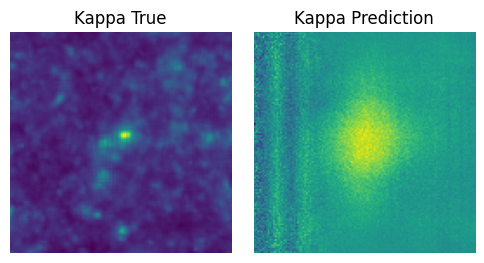

In [ ]:
plot_kappa(y.squeeze().numpy(), test_pred.squeeze())

# Second Try

## Architecture

### Blocks

In [ ]:
class DoubleConv2d(nn.Module):
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 kernel_size:int=3,
                 stride:int=1,
                 padding:int=1,
                 conv_bias:bool=False):
        super(DoubleConv2d, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=conv_bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=conv_bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            #nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=conv_bias) # TF is this doing here??
        )

    def forward(self, x):
        return self.block(x)

class ResConv3d(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, kernel_size:int=3, stride:int=1, padding:int=1, conv_bias:bool=False):
        super(ResConv3d, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding, bias=conv_bias),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.adjust_channels = nn.Conv3d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity() # Needed when the channels don't match

    def forward(self, x):
        return self.conv(x) + self.adjust_channels(x)

### Encoders

In [ ]:
class encoder1(nn.Module):
    def __init__(self, in_channels=3, channels1=8, channels2=16, channels3=32):
        super(encoder1, self).__init__()

        self.conv1 = DoubleConv2d(in_channels, channels1, conv_bias=True)
        self.conv2 = DoubleConv2d(channels1, channels2, conv_bias=True)
        self.conv3 = DoubleConv2d(channels2, channels3, conv_bias=True)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)

        return x

# TODO: Remove MaxPool2d and replace with only convolutions

model = encoder1()
summary(model, input_size=(1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
encoder1                                 [1, 32, 32, 32]           --
├─DoubleConv2d: 1-1                      [1, 8, 128, 128]          --
│    └─Sequential: 2-1                   [1, 8, 128, 128]          --
│    │    └─Conv2d: 3-1                  [1, 8, 128, 128]          224
│    │    └─BatchNorm2d: 3-2             [1, 8, 128, 128]          16
│    │    └─ReLU: 3-3                    [1, 8, 128, 128]          --
│    │    └─Conv2d: 3-4                  [1, 8, 128, 128]          584
│    │    └─BatchNorm2d: 3-5             [1, 8, 128, 128]          16
│    │    └─ReLU: 3-6                    [1, 8, 128, 128]          --
├─MaxPool2d: 1-2                         [1, 8, 64, 64]            --
├─DoubleConv2d: 1-3                      [1, 16, 64, 64]           --
│    └─Sequential: 2-2                   [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-7                  [1, 16, 64, 64]           1,168
│    │    

### Decoders

In [ ]:
class decoder1(nn.Module):
    def __init__(self, out_channels=1, channels1=8, channels2=16, channels3=32):
        super(decoder1, self).__init__()

        self.conv1 = DoubleConv2d(channels3, channels2, conv_bias=True)
        self.conv2 = DoubleConv2d(channels2, channels1, conv_bias=True)
        self.conv3 = DoubleConv2d(channels1, out_channels, conv_bias=True)

        self.pool = nn.Upsample(scale_factor=2, mode='bilinear') # TODO: Nearest

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)

        return x
# TODO: Transpose Convolution

model = decoder1()
summary(model, input_size=(1, 32, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
decoder1                                 [1, 1, 128, 128]          --
├─DoubleConv2d: 1-1                      [1, 16, 32, 32]           --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 32, 32]           4,624
│    │    └─BatchNorm2d: 3-2             [1, 16, 32, 32]           32
│    │    └─ReLU: 3-3                    [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-4                  [1, 16, 32, 32]           2,320
│    │    └─BatchNorm2d: 3-5             [1, 16, 32, 32]           32
│    │    └─ReLU: 3-6                    [1, 16, 32, 32]           --
├─Upsample: 1-2                          [1, 16, 64, 64]           --
├─DoubleConv2d: 1-3                      [1, 8, 64, 64]            --
│    └─Sequential: 2-2                   [1, 8, 64, 64]            --
│    │    └─Conv2d: 3-7                  [1, 8, 64, 64]            1,160
│    │

### Basic CNN

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.encoder = encoder1()
        self.decoder = decoder1()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = BasicCNN()
summary(model, input_size=(1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
BasicCNN                                 [1, 1, 128, 128]          --
├─encoder1: 1-1                          [1, 32, 32, 32]           --
│    └─DoubleConv2d: 2-1                 [1, 8, 128, 128]          --
│    │    └─Sequential: 3-1              [1, 8, 128, 128]          840
│    └─MaxPool2d: 2-2                    [1, 8, 64, 64]            --
│    └─DoubleConv2d: 2-3                 [1, 16, 64, 64]           --
│    │    └─Sequential: 3-2              [1, 16, 64, 64]           3,552
│    └─MaxPool2d: 2-4                    [1, 16, 32, 32]           --
│    └─DoubleConv2d: 2-5                 [1, 32, 32, 32]           --
│    │    └─Sequential: 3-3              [1, 32, 32, 32]           14,016
├─decoder1: 1-2                          [1, 1, 128, 128]          --
│    └─DoubleConv2d: 2-6                 [1, 16, 32, 32]           --
│    │    └─Sequential: 3-4              [1, 16, 32, 32]           7,008
│   

## Train

In [ ]:
print(f'Using device: {DEVICE}')

model = BasicCNN().to(DEVICE)
model = torch.compile(model)

criterion = WeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

metrics = {
    'wmape': wmape,
    'dicee': dicee,
    'dpeaks': dpeaks
}

Using device: cuda


In [ ]:
train(model, train_loader, val_loader, criterion, optimizer, epochs=100, start_epoch=1, metrics=metrics, device=DEVICE)

Epoch: 1/100, Loss: 215509.4375:   5%|▍         | 4/88 [00:18<03:35,  2.57s/it]

num is nan


Epoch: 1/100, Loss: 209115.5781:   9%|▉         | 8/88 [00:19<03:13,  2.41s/it]


KeyboardInterrupt: 

In [ ]:
history = {'train_losses': [719129.4884832249,
  641908.5981499663,
  573176.4021635154,
  463530.8255589374,
  336372.2056247896,
  222490.603869081,
  147134.110222523,
  125696.4366510744,
  116784.73268854494,
  112212.95418326414,
  109378.82364631255,
  107133.82511553944,
  104830.65966323497,
  102835.14105410893,
  100944.58392695594,
  98896.78854923489,
  96309.06482762007,
  93024.0091296321,
  88787.92908324099,
  82894.86506676392,
  74367.54551254629,
  62025.837152417385,
  46116.9550795276,
  31046.197058127385,
  21190.55157806013,
  17691.692206785796,
  16623.282729855986,
  15728.345590916742,
  15053.382846359718,
  14536.85348699217,
  14119.388997015962,
  13733.01289822974,
  13364.438421422661,
  13024.726268128647,
  12709.841582309578,
  12417.137161260362,
  12146.337528413673,
  11908.449657392244,
  11678.132469114238,
  11459.717843764902,
  11262.750774280816,
  11076.614477626725,
  10904.562070211688,
  10729.434916032282,
  10565.237826149083,
  10403.175862546199,
  10241.957146482622,
  10080.113042818408,
  9919.520330711926,
  9756.7898212426],
 'val_losses': [522907.5770517677,
  576341.7555134681,
  466261.6896517256,
  368866.06873421714,
  273359.261858165,
  167190.0352035985,
  130945.64985006313,
  116018.79798505892,
  110165.97695180976,
  107733.80634075127,
  103319.96551978115,
  100327.63540088384,
  98350.95221222643,
  94358.21033643729,
  90979.08489583334,
  85587.71719670665,
  80841.36827651515,
  74535.63848905724,
  67913.29396701389,
  57734.84315156776,
  45935.00343539562,
  30511.08408236006,
  18720.19238840225,
  13549.326786254473,
  12664.561252498948,
  16895.589420901724,
  15976.892130287248,
  15181.164808896254,
  14815.153946364688,
  14246.530510837541,
  13668.056977654145,
  13535.117273319129,
  13127.910715225169,
  12638.96512455282,
  12313.56412990583,
  11691.479779237688,
  11577.12585753367,
  11716.688687493424,
  11628.167786918666,
  11529.577830387205,
  11136.912703861532,
  10862.950024825073,
  10328.534751815025,
  10595.16601529619,
  10118.831951842645,
  10228.879053885206,
  9917.803553931239,
  10057.686666633786,
  9801.454936572758,
  9432.964402570627],
 'train_wmape': [np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan],
 'train_dicee': [0.6546124512246096,
  0.6410395706577404,
  0.621285734570433,
  0.5896764454336526,
  0.5690658476879181,
  0.5554384377957247,
  0.5399806791190828,
  0.5286289582346672,
  0.5053187582180358,
  0.46000520112912574,
  0.44523144164248046,
  0.4406286052570309,
  0.4385782763174663,
  0.4375187207381216,
  0.43691544751076555,
  0.43634537437017773,
  0.4360700487876495,
  0.43579807257951914,
  0.43552378640782685,
  0.43532097592174046,
  0.43518002433451547,
  0.43495904934898527,
  0.4348939246292388,
  0.435471813811434,
  0.437100870562199,
  0.44186231640553775,
  0.4423098912358926,
  0.4424959376427601,
  0.44235334422044736,
  0.44188804626464845,
  0.44169976965957314,
  0.44186962078888925,
  0.44190126045387995,
  0.4417126184091962,
  0.44157569183695466,
  0.4412465895955824,
  0.4409306214356551,
  0.44066199761960834,
  0.4403412781027104,
  0.440060146214504,
  0.4397329548102949,
  0.43954191584561414,
  0.43383342941530734,
  0.43002472251279134,
  0.4270458899665778,
  0.4241010133625147,
  0.4280172216614016,
  0.4234272660430073,
  0.4233025671977757,
  0.4232615098062923],
 'train_dpeaks': [246.07324955116695,
  285.9682226211849,
  299.2113105924596,
  281.8096947935368,
  278.21723518850985,
  283.7084380610413,
  295.8244165170557,
  305.78527827648116,
  311.55906642728905,
  314.9120287253142,
  319.3556552962298,
  323.7556552962298,
  328.16391382405743,
  331.1517055655296,
  334.4276481149013,
  336.0800718132855,
  339.5560143626571,
  343.0,
  346.54649910233394,
  348.33931777378814,
  343.3488330341113,
  328.1068222621185,
  306.6906642728905,
  295.02872531418313,
  290.8698384201077,
  290.3375224416517,
  291.26912028725314,
  292.4276481149013,
  296.02710951526035,
  300.16588868940755,
  304.51472172351885,
  307.1955116696589,
  309.16481149012566,
  312.1394973070018,
  313.3806104129264,
  313.8456014362657,
  315.01597845601435,
  314.70305206463195,
  315.4312387791741,
  315.73123877917413,
  315.46768402154396,
  315.0883303411131,
  314.64811490125675,
  313.30179533213646,
  315.1296229802513,
  315.5698384201077,
  314.81921005386,
  315.89748653500897,
  315.19389587073607,
  315.81364452423696],
 'val_wmape': [np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan,
  np.nan],
 'val_dicee': [0.010765562234101472,
  0.01045873462150394,
  0.010053852953092017,
  0.009523818830046991,
  0.009111007777127353,
  0.008830015747635454,
  0.008660956504770402,
  0.0084454489476753,
  0.007912124648238674,
  0.007288729060779918,
  0.007169328996228048,
  0.007103981112791633,
  0.007094181868363711,
  0.007059704294108381,
  0.00708211230910587,
  0.007067471521872061,
  0.007055386148317896,
  0.007054535507754445,
  0.007043185057463469,
  0.007046736330295652,
  0.007038404122747556,
  0.007036650220954458,
  0.007058056396266025,
  0.007070031390848385,
  0.0071211442000135424,
  0.0071534993672611735,
  0.007147977930126768,
  0.007155713248333144,
  0.0071418302629130456,
  0.00713455845611264,
  0.007143504571433019,
  0.007138511187299735,
  0.007146270467777445,
  0.007139918017467666,
  0.007129852418546323,
  0.007131204059228351,
  0.0071233346406056825,
  0.007117081049716834,
  0.007114370503409543,
  0.007110455220797247,
  0.007105224301116635,
  0.007107443881757332,
  0.006852730677184031,
  0.006845388067290438,
  0.0068472040622724025,
  0.006842212323789243,
  0.006841115277222913,
  0.0068415116380762175,
  0.006837397874003709,
  0.0068409274724196105],
 'val_dpeaks': [4.151117747992748,
  4.796905756280756,
  4.666526644651645,
  4.349920681170682,
  4.360512173012173,
  4.589115514115514,
  4.808870758870759,
  4.901263435638436,
  5.043663396788397,
  5.107156500906501,
  5.190195221445221,
  5.253302253302253,
  5.275081746956747,
  5.372176087801088,
  5.399270752395752,
  5.403308728308729,
  5.462709628334628,
  5.55049129111629,
  5.563107031857031,
  5.545609945609946,
  5.4274855931105925,
  5.07694493006993,
  4.848959952084952,
  4.67450709013209,
  4.687665922040922,
  4.684237406112406,
  4.705944865319865,
  4.722420519295519,
  4.735012788137788,
  4.877440268065268,
  4.937367262367262,
  5.028931138306138,
  5.026057044807045,
  5.037772759647759,
  5.023161907536908,
  5.033178742553742,
  5.063909932659933,
  5.085364866614867,
  5.046892806267806,
  5.091015928515929,
  5.063224391349391,
  5.055120920745921,
  5.032926217301218,
  5.0063163688163685,
  5.03878367003367,
  5.052551152551152,
  5.043935347060347,
  5.024972481222481,
  5.041423853923853,
  5.070991161616162]}

## Test

In [ ]:
# Load Model
checkpoint = torch.load('basic_CNN_model_5E.pth')

checkpoint.keys()

dict_keys(['model_state_dict', 'optimizer_state_dict'])

In [ ]:
model_ = BasicCNN().to(DEVICE)
model_ = torch.compile(model_)
model_.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Test model

X, y = next(iter(test_loader))

model.eval()
with torch.inference_mode():
    test_pred = model(X.to(DEVICE))

In [ ]:
# Calculate metrics
test_pred = test_pred.to('cpu')
wmape_score = wmape(y, test_pred)
dicee_score = dicee(y, test_pred)
dpeaks_score = dpeaks(y, test_pred)

print(f"WMAPE: {wmape_score}")
print(f"DICEE: {dicee_score}")
print(f"DPeaks: {dpeaks_score}")

WMAPE: 18.286067962646484
DICEE: 0.46123206615448
DPeaks: 269.0


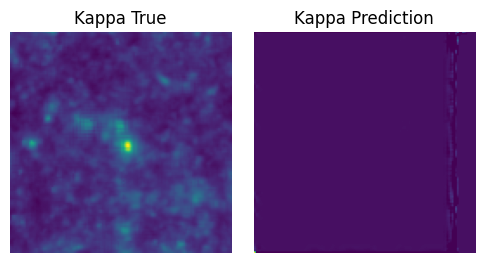

In [ ]:
plot_kappa(y.squeeze().numpy(), test_pred.squeeze())

# Third try Reference paper NET downsampled

In [ ]:
# TODO: remove Hardcode
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvBlock, self).__init__()
        self.trans_conv2d = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        self.conv2d = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size)
        self.bn = nn.BatchNorm2d(out_channels)

        self.tanh = nn.Tanh()

    def forward(self, x, multiply_input):
        x = self.tanh(self.trans_conv2d(x))
        x = self.tanh(self.conv2d(x))
        x = self.bn(x * multiply_input)
        return x


class ConvNet2(nn.Module):
    def __init__(self, channel1: int = 8, channel2: int = 16, kernel_size=49):
        super(ConvNet2, self).__init__()
        self.conv2d_1 = nn.Conv2d(in_channels=3, out_channels=channel1, kernel_size=3, padding=1)
        self.avg_pool = nn.AvgPool2d(kernel_size=2) # kernel_size=3

        self.block1 = ConvBlock(in_channels=channel1, out_channels=channel1, kernel_size=kernel_size)
        self.block2 = ConvBlock(in_channels=channel1, out_channels=channel1, kernel_size=kernel_size)
        self.block3 = ConvBlock(in_channels=channel1, out_channels=channel1, kernel_size=kernel_size)
        self.block4 = ConvBlock(in_channels=channel1, out_channels=channel1, kernel_size=kernel_size)

        self.trans_conv2d_5 = nn.ConvTranspose2d(in_channels=channel1, out_channels=channel2, kernel_size=kernel_size)
        self.out_conv = nn.Conv2d(in_channels=channel2, out_channels=1, kernel_size=kernel_size)

        self.tanh = nn.Tanh()

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x):
        x = self.avg_pool(self.tanh(self.conv2d_1(x)))
        #x = self.tanh(self.conv2d_1(x))
        avg_pool = x.clone()

        x = self.block1(x, avg_pool)
        multiply_1 = x.clone()

        x = self.block2(x, multiply_1)
        multiply_2 = x.clone()

        x = self.block3(x, multiply_2)

        x = self.block4(x, multiply_1)

        x = self.tanh(self.trans_conv2d_5(x))

        x = self.out_conv(x)

        return self.upsample(x)

In [ ]:
model = ConvNet2(channel1=8, channel2=16, kernel_size=49).to(DEVICE)
summary(model, (1, 3, 128, 128), device=DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet2                                 [1, 1, 128, 128]          --
├─Conv2d: 1-1                            [1, 8, 128, 128]          224
├─Tanh: 1-2                              [1, 8, 128, 128]          --
├─AvgPool2d: 1-3                         [1, 8, 64, 64]            --
├─ConvBlock: 1-4                         [1, 8, 64, 64]            --
│    └─ConvTranspose2d: 2-1              [1, 8, 112, 112]          153,672
│    └─Tanh: 2-2                         [1, 8, 112, 112]          --
│    └─Conv2d: 2-3                       [1, 8, 64, 64]            153,672
│    └─Tanh: 2-4                         [1, 8, 64, 64]            --
│    └─BatchNorm2d: 2-5                  [1, 8, 64, 64]            16
├─ConvBlock: 1-5                         [1, 8, 64, 64]            --
│    └─ConvTranspose2d: 2-6              [1, 8, 112, 112]          153,672
│    └─Tanh: 2-7                         [1, 8, 112, 112]          --

## Training

In [ ]:
print(f'Using device: {DEVICE}')

model = ConvNet2(channel1=8, channel2=16, kernel_size=49).to(DEVICE)
model = torch.compile(model)

criterion = WeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

metrics = {
    'wmape': wmape,
    'dicee': dicee,
    'dpeaks': dpeaks
}

Using device: cuda


In [ ]:
RESUME_TRAINING = False
CHECKPOINT_FILEPATH = os.path.join(MODELS_PATH, 'basic_CNN_model_1E.pth') # the model should be in the models folder

if RESUME_TRAINING:
    last_epoch, history = load_checkpoint(model, optimizer, CHECKPOINT_FILEPATH)
else:
    last_epoch = 0

# TODO: integrate history

In [ ]:
history = train(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS, start_epoch=last_epoch+1,metrics=metrics, device=DEVICE)

Epoch: 1/50, Loss: 54.7706: 100%|██████████| 88/88 [03:33<00:00,  2.43s/it]  


Train Metrics: Loss: 3920.2434, wmape: inf, dicee: 0.4979, dpeaks: 222.8280


Epoch: 1/50, Loss: 385.8822: 100%|██████████| 24/24 [00:34<00:00,  1.46s/it] 


Val Metrics: Loss: 1906.4142, wmape: inf, dicee: 0.4641, dpeaks: 264.9657




Epoch: 2/50, Loss: 48.9378: 100%|██████████| 88/88 [03:06<00:00,  2.12s/it]  


Train Metrics: Loss: 1549.5789, wmape: inf, dicee: 0.4353, dpeaks: 196.1788


Epoch: 2/50, Loss: 373.0297: 100%|██████████| 24/24 [00:31<00:00,  1.32s/it] 


Val Metrics: Loss: 1809.6435, wmape: inf, dicee: 0.4242, dpeaks: 174.7178




Epoch: 3/50, Loss: 33.8924: 100%|██████████| 88/88 [03:06<00:00,  2.12s/it]  


Train Metrics: Loss: 1352.8789, wmape: inf, dicee: 0.4109, dpeaks: 181.9074


Epoch: 3/50, Loss: 266.5529: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it] 


Val Metrics: Loss: 1302.1016, wmape: inf, dicee: 0.4037, dpeaks: 189.5084




Epoch: 4/50, Loss: 39.1137: 100%|██████████| 88/88 [03:08<00:00,  2.14s/it]  


Train Metrics: Loss: 1230.1386, wmape: inf, dicee: 0.3963, dpeaks: 174.4197


Epoch: 4/50, Loss: 287.0923: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it] 


Val Metrics: Loss: 1373.5208, wmape: inf, dicee: 0.4027, dpeaks: 182.8040




Epoch: 5/50, Loss: 29.4520: 100%|██████████| 88/88 [03:04<00:00,  2.10s/it]  


Train Metrics: Loss: 1152.3231, wmape: inf, dicee: 0.3848, dpeaks: 170.7145


Epoch: 5/50, Loss: 260.2979: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it] 


Val Metrics: Loss: 1246.5289, wmape: inf, dicee: 0.3938, dpeaks: 181.6869
Checkpoint saved to models/baseline_CNN_2_model_5E.pth



Epoch: 6/50, Loss: 37.5720: 100%|██████████| 88/88 [02:58<00:00,  2.03s/it]  


Train Metrics: Loss: 1087.2417, wmape: inf, dicee: 0.3754, dpeaks: 168.0460


Epoch: 6/50, Loss: 229.5807: 100%|██████████| 24/24 [00:57<00:00,  2.40s/it] 


Val Metrics: Loss: 1117.0401, wmape: inf, dicee: 0.3750, dpeaks: 166.9811




Epoch: 7/50, Loss: 30.5619: 100%|██████████| 88/88 [03:39<00:00,  2.50s/it]  


Train Metrics: Loss: 1041.4783, wmape: inf, dicee: 0.3674, dpeaks: 166.7522


Epoch: 7/50, Loss: 264.7498: 100%|██████████| 24/24 [00:26<00:00,  1.12s/it] 


Val Metrics: Loss: 1206.2993, wmape: inf, dicee: 0.3700, dpeaks: 165.9562




Epoch: 8/50, Loss: 40.7688: 100%|██████████| 88/88 [03:03<00:00,  2.09s/it]  


Train Metrics: Loss: 1008.1576, wmape: inf, dicee: 0.3604, dpeaks: 167.7338


Epoch: 8/50, Loss: 278.0013: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it] 


Val Metrics: Loss: 1316.7121, wmape: inf, dicee: 0.3937, dpeaks: 180.0579




Epoch: 9/50, Loss: 33.6615: 100%|██████████| 88/88 [03:05<00:00,  2.11s/it]  


Train Metrics: Loss: 958.2343, wmape: inf, dicee: 0.3507, dpeaks: 164.9264


Epoch: 9/50, Loss: 297.4264: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it] 


Val Metrics: Loss: 1447.8496, wmape: inf, dicee: 0.3746, dpeaks: 229.1293




Epoch: 10/50, Loss: 25.4787: 100%|██████████| 88/88 [03:06<00:00,  2.12s/it]  


Train Metrics: Loss: 944.8484, wmape: inf, dicee: 0.3471, dpeaks: 167.3395


Epoch: 10/50, Loss: 237.2348: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it] 


Val Metrics: Loss: 1079.2273, wmape: inf, dicee: 0.3442, dpeaks: 161.8519
Checkpoint saved to models/baseline_CNN_2_model_10E.pth



Epoch: 11/50, Loss: 37.9681: 100%|██████████| 88/88 [03:05<00:00,  2.11s/it]  


Train Metrics: Loss: 899.8675, wmape: inf, dicee: 0.3398, dpeaks: 164.7285


Epoch: 11/50, Loss: 231.5194: 100%|██████████| 24/24 [00:30<00:00,  1.25s/it] 


Val Metrics: Loss: 1088.9115, wmape: inf, dicee: 0.3582, dpeaks: 178.4162




Epoch: 12/50, Loss: 26.0798: 100%|██████████| 88/88 [03:38<00:00,  2.48s/it] 


Train Metrics: Loss: 894.7687, wmape: inf, dicee: 0.3373, dpeaks: 164.3749


Epoch: 12/50, Loss: 211.3974: 100%|██████████| 24/24 [00:34<00:00,  1.45s/it] 


Val Metrics: Loss: 1017.7844, wmape: inf, dicee: 0.3462, dpeaks: 161.8492




Epoch: 13/50, Loss: 23.5927: 100%|██████████| 88/88 [03:40<00:00,  2.50s/it] 


Train Metrics: Loss: 887.1920, wmape: inf, dicee: 0.3356, dpeaks: 165.7110


Epoch: 13/50, Loss: 279.3838: 100%|██████████| 24/24 [00:35<00:00,  1.47s/it] 


Val Metrics: Loss: 1372.2460, wmape: inf, dicee: 0.3549, dpeaks: 168.6175




Epoch: 14/50, Loss: 27.6881: 100%|██████████| 88/88 [03:41<00:00,  2.52s/it] 


Train Metrics: Loss: 859.9778, wmape: inf, dicee: 0.3304, dpeaks: 164.6373


Epoch: 14/50, Loss: 211.9294: 100%|██████████| 24/24 [00:35<00:00,  1.49s/it] 


Val Metrics: Loss: 979.5300, wmape: inf, dicee: 0.3444, dpeaks: 162.7461




Epoch: 15/50, Loss: 27.1969: 100%|██████████| 88/88 [03:41<00:00,  2.52s/it] 


Train Metrics: Loss: 847.2560, wmape: inf, dicee: 0.3270, dpeaks: 165.0413


Epoch: 15/50, Loss: 252.4236: 100%|██████████| 24/24 [00:35<00:00,  1.47s/it] 


Val Metrics: Loss: 1231.0480, wmape: inf, dicee: 0.3323, dpeaks: 166.1246
Checkpoint saved to models/baseline_CNN_2_model_15E.pth



Epoch: 16/50, Loss: 23.2343: 100%|██████████| 88/88 [03:39<00:00,  2.50s/it] 


Train Metrics: Loss: 829.5884, wmape: inf, dicee: 0.3246, dpeaks: 163.3162


Epoch: 16/50, Loss: 187.5487: 100%|██████████| 24/24 [00:34<00:00,  1.45s/it]


Val Metrics: Loss: 910.4139, wmape: inf, dicee: 0.3368, dpeaks: 169.8606




Epoch: 17/50, Loss: 21.5526: 100%|██████████| 88/88 [03:21<00:00,  2.29s/it] 


Train Metrics: Loss: 819.4827, wmape: inf, dicee: 0.3215, dpeaks: 164.0510


Epoch: 17/50, Loss: 190.2682: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it]


Val Metrics: Loss: 909.2956, wmape: inf, dicee: 0.3320, dpeaks: 169.9502




Epoch: 18/50, Loss: 27.3560: 100%|██████████| 88/88 [03:01<00:00,  2.06s/it] 


Train Metrics: Loss: 813.7552, wmape: inf, dicee: 0.3202, dpeaks: 163.0513


Epoch: 18/50, Loss: 361.9850: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it] 


Val Metrics: Loss: 1695.6126, wmape: inf, dicee: 0.3389, dpeaks: 173.1933




Epoch: 19/50, Loss: 20.3014: 100%|██████████| 88/88 [02:51<00:00,  1.95s/it] 


Train Metrics: Loss: 806.1240, wmape: inf, dicee: 0.3180, dpeaks: 164.6467


Epoch: 19/50, Loss: 349.8958: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it] 


Val Metrics: Loss: 1663.0513, wmape: inf, dicee: 0.3495, dpeaks: 177.6741




Epoch: 20/50, Loss: 22.0984: 100%|██████████| 88/88 [02:55<00:00,  2.00s/it] 


Train Metrics: Loss: 791.2065, wmape: inf, dicee: 0.3156, dpeaks: 164.0603


Epoch: 20/50, Loss: 207.9641: 100%|██████████| 24/24 [00:31<00:00,  1.31s/it] 


Val Metrics: Loss: 976.3585, wmape: inf, dicee: 0.3276, dpeaks: 167.2343
Checkpoint saved to models/baseline_CNN_2_model_20E.pth



Epoch: 21/50, Loss: 24.5486: 100%|██████████| 88/88 [02:58<00:00,  2.02s/it] 


Train Metrics: Loss: 782.0692, wmape: inf, dicee: 0.3135, dpeaks: 163.9370


Epoch: 21/50, Loss: 180.2020: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


Val Metrics: Loss: 860.8091, wmape: inf, dicee: 0.3301, dpeaks: 168.6135




Epoch: 22/50, Loss: 28.5306: 100%|██████████| 88/88 [03:06<00:00,  2.12s/it] 


Train Metrics: Loss: 796.2381, wmape: inf, dicee: 0.3147, dpeaks: 164.7445


Epoch: 22/50, Loss: 193.2978: 100%|██████████| 24/24 [00:26<00:00,  1.11s/it]


Val Metrics: Loss: 924.8603, wmape: inf, dicee: 0.3346, dpeaks: 170.2337




Epoch: 23/50, Loss: 28.7822: 100%|██████████| 88/88 [03:47<00:00,  2.59s/it] 


Train Metrics: Loss: 773.4315, wmape: inf, dicee: 0.3111, dpeaks: 163.7921


Epoch: 23/50, Loss: 449.7166: 100%|██████████| 24/24 [00:38<00:00,  1.60s/it] 


Val Metrics: Loss: 2139.1405, wmape: inf, dicee: 0.3384, dpeaks: 164.7461




Epoch: 24/50, Loss: 24.3046: 100%|██████████| 88/88 [02:59<00:00,  2.03s/it] 


Train Metrics: Loss: 763.4396, wmape: inf, dicee: 0.3086, dpeaks: 162.7948


Epoch: 24/50, Loss: 346.6560: 100%|██████████| 24/24 [00:38<00:00,  1.60s/it] 


Val Metrics: Loss: 1635.4512, wmape: inf, dicee: 0.3303, dpeaks: 162.1441




Epoch: 25/50, Loss: 25.5689: 100%|██████████| 88/88 [04:16<00:00,  2.92s/it] 


Train Metrics: Loss: 757.7726, wmape: inf, dicee: 0.3070, dpeaks: 163.8323


Epoch: 25/50, Loss: 212.4045: 100%|██████████| 24/24 [00:39<00:00,  1.65s/it] 


Val Metrics: Loss: 998.3607, wmape: inf, dicee: 0.3384, dpeaks: 180.3340
Checkpoint saved to models/baseline_CNN_2_model_25E.pth



Epoch: 26/50, Loss: 28.0032: 100%|██████████| 88/88 [03:52<00:00,  2.64s/it] 


Train Metrics: Loss: 756.9892, wmape: inf, dicee: 0.3067, dpeaks: 165.3576


Epoch: 26/50, Loss: 212.6346: 100%|██████████| 24/24 [00:36<00:00,  1.51s/it] 


Val Metrics: Loss: 1037.8955, wmape: inf, dicee: 0.3350, dpeaks: 162.3111




Epoch: 27/50, Loss: 24.6015: 100%|██████████| 88/88 [03:46<00:00,  2.58s/it] 


Train Metrics: Loss: 748.3666, wmape: inf, dicee: 0.3044, dpeaks: 164.0390


Epoch: 27/50, Loss: 212.5774: 100%|██████████| 24/24 [00:36<00:00,  1.50s/it] 


Val Metrics: Loss: 1029.9297, wmape: inf, dicee: 0.3303, dpeaks: 165.1327




Epoch: 28/50, Loss: 22.5264: 100%|██████████| 88/88 [03:28<00:00,  2.37s/it] 


Train Metrics: Loss: 754.3423, wmape: inf, dicee: 0.3050, dpeaks: 163.9652


Epoch: 28/50, Loss: 235.9453: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it] 


Val Metrics: Loss: 1124.2105, wmape: inf, dicee: 0.3405, dpeaks: 185.9165




Epoch: 29/50, Loss: 33.0875: 100%|██████████| 88/88 [03:20<00:00,  2.28s/it] 


Train Metrics: Loss: 740.2964, wmape: inf, dicee: 0.3020, dpeaks: 163.9445


Epoch: 29/50, Loss: 337.7886: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it] 


Val Metrics: Loss: 1625.0079, wmape: inf, dicee: 0.3231, dpeaks: 164.0660




Epoch: 30/50, Loss: 24.2515: 100%|██████████| 88/88 [02:51<00:00,  1.94s/it] 


Train Metrics: Loss: 726.9010, wmape: inf, dicee: 0.2993, dpeaks: 164.5899


Epoch: 30/50, Loss: 172.5873: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]


Val Metrics: Loss: 823.5898, wmape: inf, dicee: 0.3127, dpeaks: 162.6700
Checkpoint saved to models/baseline_CNN_2_model_30E.pth



Epoch: 31/50, Loss: 24.8072: 100%|██████████| 88/88 [02:44<00:00,  1.87s/it] 


Train Metrics: Loss: 724.2173, wmape: inf, dicee: 0.2981, dpeaks: 164.2770


Epoch: 31/50, Loss: 193.7438: 100%|██████████| 24/24 [00:26<00:00,  1.10s/it]


Val Metrics: Loss: 906.8668, wmape: inf, dicee: 0.3195, dpeaks: 163.2027




Epoch: 32/50, Loss: 25.4768: 100%|██████████| 88/88 [02:42<00:00,  1.85s/it] 


Train Metrics: Loss: 708.7265, wmape: inf, dicee: 0.2948, dpeaks: 164.6966


Epoch: 32/50, Loss: 168.1483: 100%|██████████| 24/24 [00:26<00:00,  1.12s/it]


Val Metrics: Loss: 793.1397, wmape: inf, dicee: 0.3124, dpeaks: 162.9111




Epoch: 33/50, Loss: 22.8154: 100%|██████████| 88/88 [02:42<00:00,  1.84s/it] 


Train Metrics: Loss: 709.5643, wmape: inf, dicee: 0.2944, dpeaks: 164.0776


Epoch: 33/50, Loss: 220.5580: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it] 


Val Metrics: Loss: 1051.2231, wmape: inf, dicee: 0.3238, dpeaks: 190.4983




Epoch: 34/50, Loss: 19.5852: 100%|██████████| 88/88 [02:33<00:00,  1.75s/it] 


Train Metrics: Loss: 714.8905, wmape: inf, dicee: 0.2957, dpeaks: 165.4384


Epoch: 34/50, Loss: 189.4515: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Val Metrics: Loss: 903.3903, wmape: inf, dicee: 0.3236, dpeaks: 177.1333




Epoch: 35/50, Loss: 20.5633: 100%|██████████| 88/88 [02:31<00:00,  1.72s/it] 


Train Metrics: Loss: 702.3897, wmape: inf, dicee: 0.2920, dpeaks: 164.2548


Epoch: 35/50, Loss: 209.1934: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it] 


Val Metrics: Loss: 995.1907, wmape: inf, dicee: 0.3327, dpeaks: 182.4727
Checkpoint saved to models/baseline_CNN_2_model_35E.pth



Epoch: 36/50, Loss: 27.9995: 100%|██████████| 88/88 [02:31<00:00,  1.72s/it] 


Train Metrics: Loss: 711.1950, wmape: inf, dicee: 0.2937, dpeaks: 165.4413


Epoch: 36/50, Loss: 266.2236: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it] 


Val Metrics: Loss: 1246.6247, wmape: inf, dicee: 0.3232, dpeaks: 168.3724




Epoch: 37/50, Loss: 28.3706: 100%|██████████| 88/88 [02:31<00:00,  1.72s/it] 


Train Metrics: Loss: 695.5189, wmape: inf, dicee: 0.2905, dpeaks: 163.8014


Epoch: 37/50, Loss: 186.4230: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Val Metrics: Loss: 891.5501, wmape: inf, dicee: 0.3229, dpeaks: 165.4498




Epoch: 38/50, Loss: 28.9240: 100%|██████████| 88/88 [02:31<00:00,  1.72s/it] 


Train Metrics: Loss: 689.5715, wmape: inf, dicee: 0.2889, dpeaks: 165.1932


Epoch: 38/50, Loss: 767.6708: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it] 


Val Metrics: Loss: 3568.3893, wmape: inf, dicee: 0.3360, dpeaks: 171.0828




Epoch: 39/50, Loss: 26.3758: 100%|██████████| 88/88 [02:31<00:00,  1.72s/it] 


Train Metrics: Loss: 689.2564, wmape: inf, dicee: 0.2883, dpeaks: 163.8553


Epoch: 39/50, Loss: 361.5727: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it] 


Val Metrics: Loss: 1778.0007, wmape: inf, dicee: 0.3384, dpeaks: 175.3684




Epoch: 40/50, Loss: 26.5208: 100%|██████████| 88/88 [02:31<00:00,  1.72s/it] 


Train Metrics: Loss: 683.6128, wmape: inf, dicee: 0.2870, dpeaks: 164.6614


Epoch: 40/50, Loss: 244.0877: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it] 


Val Metrics: Loss: 1201.2920, wmape: inf, dicee: 0.3275, dpeaks: 169.5798
Checkpoint saved to models/baseline_CNN_2_model_40E.pth



Epoch: 41/50, Loss: 27.6567: 100%|██████████| 88/88 [02:31<00:00,  1.73s/it] 


Train Metrics: Loss: 680.2581, wmape: inf, dicee: 0.2860, dpeaks: 164.9210


Epoch: 41/50, Loss: 187.4104: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Val Metrics: Loss: 870.4304, wmape: inf, dicee: 0.3227, dpeaks: 166.3333




Epoch: 42/50, Loss: 20.3061: 100%|██████████| 88/88 [02:31<00:00,  1.72s/it] 


Train Metrics: Loss: 672.7895, wmape: inf, dicee: 0.2843, dpeaks: 165.0126


Epoch: 42/50, Loss: 501.0536: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it] 


Val Metrics: Loss: 2432.8076, wmape: inf, dicee: 0.3310, dpeaks: 167.4700




Epoch: 43/50, Loss: 21.6045: 100%|██████████| 88/88 [02:31<00:00,  1.72s/it] 


Train Metrics: Loss: 673.5267, wmape: inf, dicee: 0.2842, dpeaks: 164.0670


Epoch: 43/50, Loss: 178.1138: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


Val Metrics: Loss: 847.6415, wmape: inf, dicee: 0.3218, dpeaks: 162.8242




Epoch: 44/50, Loss: 24.9774: 100%|██████████| 88/88 [02:31<00:00,  1.73s/it] 


Train Metrics: Loss: 660.1095, wmape: inf, dicee: 0.2812, dpeaks: 163.7562


Epoch: 44/50, Loss: 175.1533: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Val Metrics: Loss: 816.5977, wmape: inf, dicee: 0.3126, dpeaks: 167.3529




Epoch: 45/50, Loss: 18.5510: 100%|██████████| 88/88 [02:31<00:00,  1.72s/it] 


Train Metrics: Loss: 655.4715, wmape: inf, dicee: 0.2800, dpeaks: 164.1118


Epoch: 45/50, Loss: 201.2088: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Val Metrics: Loss: 929.2528, wmape: inf, dicee: 0.3295, dpeaks: 195.4525
Checkpoint saved to models/baseline_CNN_2_model_45E.pth



Epoch: 46/50, Loss: 21.0384: 100%|██████████| 88/88 [02:31<00:00,  1.72s/it] 


Train Metrics: Loss: 666.2283, wmape: inf, dicee: 0.2815, dpeaks: 164.7627


Epoch: 46/50, Loss: 193.2073: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Val Metrics: Loss: 898.3488, wmape: inf, dicee: 0.3163, dpeaks: 162.4970




Epoch: 47/50, Loss: 32.1870: 100%|██████████| 88/88 [02:31<00:00,  1.72s/it] 


Train Metrics: Loss: 657.0726, wmape: inf, dicee: 0.2801, dpeaks: 165.4065


Epoch: 47/50, Loss: 476.8990: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it] 


Val Metrics: Loss: 2178.1151, wmape: inf, dicee: 0.3307, dpeaks: 166.0949




Epoch: 48/50, Loss: 21.5151: 100%|██████████| 88/88 [02:32<00:00,  1.73s/it] 


Train Metrics: Loss: 654.0917, wmape: inf, dicee: 0.2790, dpeaks: 164.6907


Epoch: 48/50, Loss: 609.6915: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it] 


Val Metrics: Loss: 2807.4755, wmape: inf, dicee: 0.3196, dpeaks: 166.5785




Epoch: 49/50, Loss: 23.1488: 100%|██████████| 88/88 [02:31<00:00,  1.72s/it] 


Train Metrics: Loss: 658.4422, wmape: inf, dicee: 0.2801, dpeaks: 166.1102


Epoch: 49/50, Loss: 219.8544: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it] 


Val Metrics: Loss: 1016.3740, wmape: inf, dicee: 0.3206, dpeaks: 165.3535




Epoch: 50/50, Loss: 22.8443: 100%|██████████| 88/88 [02:31<00:00,  1.72s/it] 


Train Metrics: Loss: 648.6934, wmape: inf, dicee: 0.2781, dpeaks: 165.4905


Epoch: 50/50, Loss: 215.2359: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it] 

Val Metrics: Loss: 1057.9953, wmape: inf, dicee: 0.3171, dpeaks: 166.3906
Checkpoint saved to models/baseline_CNN_2_model_50E.pth



# Fourth Try
Unet + Neural Op



In [29]:
pip install neuraloperator

In [30]:
pip install -q neuraloperator wandb torch_harmonics

In [31]:
from neuralop.models import UNO

In [ ]:
uno_model= UNO(in_channels=3, out_channels=1, hidden_channels=32, projection_channels=64,uno_out_channels = [32,64,64,64,32], \
            uno_n_modes= [[16,16],[8,8],[8,8],[8,8],[16,16]], uno_scalings=  [[1.0,1.0],[0.5,0.5],[1,1],[2,2],[1,1]],\
            horizontal_skips_map = None, n_layers = 5, domain_padding = 0.2)
summary(uno_model, (1, 3, 128, 128), device=DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
UNO                                      [1, 1, 128, 128]          --
├─MLP: 1-1                               [1, 32, 128, 128]         --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Conv2d: 3-1                  [1, 256, 128, 128]        1,024
│    │    └─Conv2d: 3-2                  [1, 32, 128, 128]         8,224
├─ModuleList: 1-6                        --                        (recursive)
│    └─FNOBlocks: 2-2                    [1, 32, 154, 154]         --
│    │    └─ModuleList: 3-3              --                        1,024
│    │    └─SpectralConv: 3-4            [1, 32, 154, 154]         294,944
├─ModuleDict: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [1, 32, 154, 154]         1,024
├─ModuleList: 1-6                        --                        (recursive)
│    └─FNOBlocks: 2-4                    

## Train

In [ ]:
print(f'Using device: {DEVICE}')

model = uno_model.to(DEVICE)

criterion = WeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

metrics = {
    'wmape': wmape,
    'dicee': dicee,
    'dpeaks': dpeaks
}

Using device: cuda


In [ ]:
MODEL_NAME = "U-Net-NO"

In [ ]:
history = train(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS, metrics=metrics, device=DEVICE)

Epoch: 1/50, Loss: 47.7905: 100%|██████████| 88/88 [02:03<00:00,  1.40s/it]


Train Metrics: Loss: 1649.4692, wmape: inf, dicee: 0.5612, dpeaks: 213.9731


Epoch: 1/50, Loss: 290.5193: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


Val Metrics: Loss: 1457.7193, wmape: inf, dicee: 0.5438, dpeaks: 207.3879




Epoch: 2/50, Loss: 40.4616: 100%|██████████| 88/88 [01:39<00:00,  1.13s/it]


Train Metrics: Loss: 1380.0396, wmape: inf, dicee: 0.4724, dpeaks: 205.5338


Epoch: 2/50, Loss: 258.7433: 100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


Val Metrics: Loss: 1286.6245, wmape: inf, dicee: 0.4101, dpeaks: 194.1791




Epoch: 3/50, Loss: 27.2171: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it]


Train Metrics: Loss: 1121.8188, wmape: inf, dicee: 0.3783, dpeaks: 188.6417


Epoch: 3/50, Loss: 204.4800: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]


Val Metrics: Loss: 982.9078, wmape: inf, dicee: 0.3556, dpeaks: 183.4579




Epoch: 4/50, Loss: 25.5768: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 901.2811, wmape: inf, dicee: 0.3394, dpeaks: 182.9153


Epoch: 4/50, Loss: 186.6581: 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]


Val Metrics: Loss: 877.1359, wmape: inf, dicee: 0.3284, dpeaks: 186.5657




Epoch: 5/50, Loss: 20.1531: 100%|██████████| 88/88 [01:24<00:00,  1.05it/s]


Train Metrics: Loss: 818.8207, wmape: inf, dicee: 0.3194, dpeaks: 186.5643


Epoch: 5/50, Loss: 170.6187: 100%|██████████| 24/24 [00:11<00:00,  2.16it/s]


Val Metrics: Loss: 805.5835, wmape: inf, dicee: 0.3149, dpeaks: 187.4512
Checkpoint saved to models/U-Net-NO_model_5E.pth



Epoch: 6/50, Loss: 25.6374: 100%|██████████| 88/88 [01:23<00:00,  1.05it/s]


Train Metrics: Loss: 790.0274, wmape: inf, dicee: 0.3127, dpeaks: 189.1955


Epoch: 6/50, Loss: 163.1515: 100%|██████████| 24/24 [00:11<00:00,  2.15it/s]


Val Metrics: Loss: 787.8755, wmape: inf, dicee: 0.3116, dpeaks: 189.6660




Epoch: 7/50, Loss: 25.3874: 100%|██████████| 88/88 [01:23<00:00,  1.05it/s]


Train Metrics: Loss: 777.2952, wmape: inf, dicee: 0.3112, dpeaks: 190.4321


Epoch: 7/50, Loss: 163.4482: 100%|██████████| 24/24 [00:11<00:00,  2.17it/s]


Val Metrics: Loss: 779.3054, wmape: inf, dicee: 0.3109, dpeaks: 192.4418




Epoch: 8/50, Loss: 26.4356: 100%|██████████| 88/88 [01:23<00:00,  1.05it/s]


Train Metrics: Loss: 772.0635, wmape: inf, dicee: 0.3107, dpeaks: 191.7943


Epoch: 8/50, Loss: 160.7583: 100%|██████████| 24/24 [00:10<00:00,  2.20it/s]


Val Metrics: Loss: 776.6598, wmape: inf, dicee: 0.3107, dpeaks: 192.4000




Epoch: 9/50, Loss: 27.4601: 100%|██████████| 88/88 [01:23<00:00,  1.05it/s]


Train Metrics: Loss: 767.0297, wmape: inf, dicee: 0.3109, dpeaks: 192.4646


Epoch: 9/50, Loss: 160.7884: 100%|██████████| 24/24 [00:10<00:00,  2.20it/s]


Val Metrics: Loss: 769.1790, wmape: inf, dicee: 0.3106, dpeaks: 192.3178




Epoch: 10/50, Loss: 20.6382: 100%|██████████| 88/88 [01:23<00:00,  1.05it/s]


Train Metrics: Loss: 761.4895, wmape: inf, dicee: 0.3106, dpeaks: 192.3101


Epoch: 10/50, Loss: 160.1954: 100%|██████████| 24/24 [00:11<00:00,  2.17it/s]


Val Metrics: Loss: 763.3027, wmape: inf, dicee: 0.3109, dpeaks: 191.8875
Checkpoint saved to models/U-Net-NO_model_10E.pth



Epoch: 11/50, Loss: 39.5674: 100%|██████████| 88/88 [01:23<00:00,  1.05it/s]


Train Metrics: Loss: 755.3320, wmape: inf, dicee: 0.3110, dpeaks: 191.7887


Epoch: 11/50, Loss: 158.6719: 100%|██████████| 24/24 [00:11<00:00,  2.17it/s]


Val Metrics: Loss: 756.7207, wmape: inf, dicee: 0.3111, dpeaks: 189.4249




Epoch: 12/50, Loss: 21.5823: 100%|██████████| 88/88 [01:24<00:00,  1.05it/s]


Train Metrics: Loss: 748.3049, wmape: inf, dicee: 0.3112, dpeaks: 191.2571


Epoch: 12/50, Loss: 163.0907: 100%|██████████| 24/24 [00:10<00:00,  2.22it/s]


Val Metrics: Loss: 759.6151, wmape: inf, dicee: 0.3113, dpeaks: 190.8586




Epoch: 13/50, Loss: 17.9664: 100%|██████████| 88/88 [01:24<00:00,  1.04it/s]


Train Metrics: Loss: 737.9316, wmape: inf, dicee: 0.3115, dpeaks: 191.0151


Epoch: 13/50, Loss: 153.7168: 100%|██████████| 24/24 [00:11<00:00,  2.15it/s]


Val Metrics: Loss: 740.1738, wmape: inf, dicee: 0.3120, dpeaks: 191.8256




Epoch: 14/50, Loss: 20.9752: 100%|██████████| 88/88 [01:24<00:00,  1.04it/s]


Train Metrics: Loss: 727.9936, wmape: inf, dicee: 0.3118, dpeaks: 190.5393


Epoch: 14/50, Loss: 152.1410: 100%|██████████| 24/24 [00:11<00:00,  2.10it/s]


Val Metrics: Loss: 732.0072, wmape: inf, dicee: 0.3122, dpeaks: 188.3152




Epoch: 15/50, Loss: 22.4937: 100%|██████████| 88/88 [01:24<00:00,  1.04it/s]


Train Metrics: Loss: 724.5428, wmape: inf, dicee: 0.3122, dpeaks: 187.7406


Epoch: 15/50, Loss: 155.4784: 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]


Val Metrics: Loss: 735.4981, wmape: inf, dicee: 0.3126, dpeaks: 186.9104
Checkpoint saved to models/U-Net-NO_model_15E.pth



Epoch: 16/50, Loss: 16.7732: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 717.0684, wmape: inf, dicee: 0.3121, dpeaks: 187.3066


Epoch: 16/50, Loss: 149.8921: 100%|██████████| 24/24 [00:11<00:00,  2.09it/s]


Val Metrics: Loss: 723.8397, wmape: inf, dicee: 0.3124, dpeaks: 187.8741




Epoch: 17/50, Loss: 21.6180: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 713.1061, wmape: inf, dicee: 0.3115, dpeaks: 186.3126


Epoch: 17/50, Loss: 147.9959: 100%|██████████| 24/24 [00:11<00:00,  2.11it/s]


Val Metrics: Loss: 719.8281, wmape: inf, dicee: 0.3115, dpeaks: 185.1529




Epoch: 18/50, Loss: 21.1288: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 710.4141, wmape: inf, dicee: 0.3108, dpeaks: 185.7680


Epoch: 18/50, Loss: 146.4982: 100%|██████████| 24/24 [00:11<00:00,  2.07it/s]


Val Metrics: Loss: 720.1900, wmape: inf, dicee: 0.3110, dpeaks: 185.7407




Epoch: 19/50, Loss: 16.5700: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s]


Train Metrics: Loss: 709.2076, wmape: inf, dicee: 0.3101, dpeaks: 184.6695


Epoch: 19/50, Loss: 145.2206: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]


Val Metrics: Loss: 726.5792, wmape: inf, dicee: 0.3100, dpeaks: 184.5589




Epoch: 20/50, Loss: 18.2543: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s]


Train Metrics: Loss: 703.0024, wmape: inf, dicee: 0.3091, dpeaks: 185.0555


Epoch: 20/50, Loss: 144.8998: 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


Val Metrics: Loss: 710.5105, wmape: inf, dicee: 0.3090, dpeaks: 186.2081
Checkpoint saved to models/U-Net-NO_model_20E.pth



Epoch: 21/50, Loss: 18.4200: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s]


Train Metrics: Loss: 697.9685, wmape: inf, dicee: 0.3079, dpeaks: 184.1969


Epoch: 21/50, Loss: 142.9331: 100%|██████████| 24/24 [00:11<00:00,  2.06it/s]


Val Metrics: Loss: 707.8420, wmape: inf, dicee: 0.3082, dpeaks: 187.9071




Epoch: 22/50, Loss: 28.1882: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s]


Train Metrics: Loss: 701.0127, wmape: inf, dicee: 0.3072, dpeaks: 184.3725


Epoch: 22/50, Loss: 141.5558: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


Val Metrics: Loss: 715.1595, wmape: inf, dicee: 0.3076, dpeaks: 186.3690




Epoch: 23/50, Loss: 22.4260: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s]


Train Metrics: Loss: 694.8336, wmape: inf, dicee: 0.3064, dpeaks: 184.2494


Epoch: 23/50, Loss: 141.5623: 100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


Val Metrics: Loss: 703.5687, wmape: inf, dicee: 0.3067, dpeaks: 185.6902




Epoch: 24/50, Loss: 17.2059: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s]


Train Metrics: Loss: 694.0745, wmape: inf, dicee: 0.3056, dpeaks: 184.0758


Epoch: 24/50, Loss: 140.2177: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]


Val Metrics: Loss: 701.9367, wmape: inf, dicee: 0.3062, dpeaks: 186.1273




Epoch: 25/50, Loss: 21.0600: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s]


Train Metrics: Loss: 690.6693, wmape: inf, dicee: 0.3052, dpeaks: 183.7706


Epoch: 25/50, Loss: 139.6507: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]


Val Metrics: Loss: 701.0422, wmape: inf, dicee: 0.3059, dpeaks: 185.5758
Checkpoint saved to models/U-Net-NO_model_25E.pth



Epoch: 26/50, Loss: 22.4478: 100%|██████████| 88/88 [01:26<00:00,  1.01it/s]


Train Metrics: Loss: 688.0065, wmape: inf, dicee: 0.3046, dpeaks: 183.1338


Epoch: 26/50, Loss: 139.2513: 100%|██████████| 24/24 [00:11<00:00,  2.06it/s]


Val Metrics: Loss: 703.6801, wmape: inf, dicee: 0.3051, dpeaks: 183.1340




Epoch: 27/50, Loss: 33.5024: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s]


Train Metrics: Loss: 687.3687, wmape: inf, dicee: 0.3041, dpeaks: 184.4546


Epoch: 27/50, Loss: 139.5492: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


Val Metrics: Loss: 699.7013, wmape: inf, dicee: 0.3049, dpeaks: 184.3939




Epoch: 28/50, Loss: 20.7671: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s]


Train Metrics: Loss: 687.6783, wmape: inf, dicee: 0.3036, dpeaks: 184.0196


Epoch: 28/50, Loss: 138.5847: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]


Val Metrics: Loss: 707.5649, wmape: inf, dicee: 0.3047, dpeaks: 185.8418




Epoch: 29/50, Loss: 43.5507: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s]


Train Metrics: Loss: 686.4197, wmape: inf, dicee: 0.3032, dpeaks: 183.8447


Epoch: 29/50, Loss: 140.1815: 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


Val Metrics: Loss: 697.5190, wmape: inf, dicee: 0.3042, dpeaks: 185.2997




Epoch: 30/50, Loss: 21.0443: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s]


Train Metrics: Loss: 684.1013, wmape: inf, dicee: 0.3030, dpeaks: 184.1056


Epoch: 30/50, Loss: 139.3651: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]


Val Metrics: Loss: 696.2328, wmape: inf, dicee: 0.3039, dpeaks: 185.4189
Checkpoint saved to models/U-Net-NO_model_30E.pth



Epoch: 31/50, Loss: 20.1421: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s]


Train Metrics: Loss: 683.4407, wmape: inf, dicee: 0.3025, dpeaks: 184.2709


Epoch: 31/50, Loss: 140.3114: 100%|██████████| 24/24 [00:11<00:00,  2.07it/s]


Val Metrics: Loss: 697.8016, wmape: inf, dicee: 0.3034, dpeaks: 184.1657




Epoch: 32/50, Loss: 19.3485: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s]


Train Metrics: Loss: 681.5570, wmape: inf, dicee: 0.3021, dpeaks: 183.9734


Epoch: 32/50, Loss: 138.0272: 100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


Val Metrics: Loss: 709.7740, wmape: inf, dicee: 0.3033, dpeaks: 186.7603




Epoch: 33/50, Loss: 17.8411: 100%|██████████| 88/88 [01:25<00:00,  1.02it/s]


Train Metrics: Loss: 683.5497, wmape: inf, dicee: 0.3020, dpeaks: 184.3465


Epoch: 33/50, Loss: 143.0627: 100%|██████████| 24/24 [00:11<00:00,  2.11it/s]


Val Metrics: Loss: 708.5021, wmape: inf, dicee: 0.3035, dpeaks: 182.5953




Epoch: 34/50, Loss: 19.4774: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s]


Train Metrics: Loss: 681.5579, wmape: inf, dicee: 0.3019, dpeaks: 183.7747


Epoch: 34/50, Loss: 136.6120: 100%|██████████| 24/24 [00:11<00:00,  2.10it/s]


Val Metrics: Loss: 691.1696, wmape: inf, dicee: 0.3028, dpeaks: 185.4653




Epoch: 35/50, Loss: 18.8801: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 680.6197, wmape: inf, dicee: 0.3015, dpeaks: 185.2077


Epoch: 35/50, Loss: 136.9052: 100%|██████████| 24/24 [00:11<00:00,  2.07it/s]


Val Metrics: Loss: 690.7092, wmape: inf, dicee: 0.3026, dpeaks: 182.0121
Checkpoint saved to models/U-Net-NO_model_35E.pth



Epoch: 36/50, Loss: 24.2550: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 678.5804, wmape: inf, dicee: 0.3011, dpeaks: 185.3614


Epoch: 36/50, Loss: 137.3365: 100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


Val Metrics: Loss: 690.5598, wmape: inf, dicee: 0.3024, dpeaks: 184.4357




Epoch: 37/50, Loss: 18.2241: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 677.6230, wmape: inf, dicee: 0.3008, dpeaks: 185.0811


Epoch: 37/50, Loss: 138.8341: 100%|██████████| 24/24 [00:11<00:00,  2.07it/s]


Val Metrics: Loss: 692.1510, wmape: inf, dicee: 0.3016, dpeaks: 184.0889




Epoch: 38/50, Loss: 33.5111: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 676.7629, wmape: inf, dicee: 0.3006, dpeaks: 186.1874


Epoch: 38/50, Loss: 134.9854: 100%|██████████| 24/24 [00:11<00:00,  2.07it/s]


Val Metrics: Loss: 689.4850, wmape: inf, dicee: 0.3018, dpeaks: 186.1428




Epoch: 39/50, Loss: 36.8678: 100%|██████████| 88/88 [01:25<00:00,  1.02it/s]


Train Metrics: Loss: 675.9397, wmape: inf, dicee: 0.3003, dpeaks: 185.1433


Epoch: 39/50, Loss: 135.0618: 100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


Val Metrics: Loss: 687.1216, wmape: inf, dicee: 0.3016, dpeaks: 183.8438




Epoch: 40/50, Loss: 22.8634: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 674.2460, wmape: inf, dicee: 0.3000, dpeaks: 185.1467


Epoch: 40/50, Loss: 135.4741: 100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


Val Metrics: Loss: 685.8997, wmape: inf, dicee: 0.3010, dpeaks: 184.5333
Checkpoint saved to models/U-Net-NO_model_40E.pth



Epoch: 41/50, Loss: 24.5097: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 673.1783, wmape: inf, dicee: 0.2996, dpeaks: 187.6657


Epoch: 41/50, Loss: 144.6194: 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]


Val Metrics: Loss: 711.2809, wmape: inf, dicee: 0.3008, dpeaks: 186.7899




Epoch: 42/50, Loss: 22.2545: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 673.1302, wmape: inf, dicee: 0.2995, dpeaks: 187.0937


Epoch: 42/50, Loss: 136.6492: 100%|██████████| 24/24 [00:11<00:00,  2.10it/s]


Val Metrics: Loss: 686.0773, wmape: inf, dicee: 0.3008, dpeaks: 186.5663




Epoch: 43/50, Loss: 17.7058: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 672.1346, wmape: inf, dicee: 0.2994, dpeaks: 187.0697


Epoch: 43/50, Loss: 134.8139: 100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


Val Metrics: Loss: 686.0518, wmape: inf, dicee: 0.3013, dpeaks: 183.8418




Epoch: 44/50, Loss: 18.4536: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 670.5340, wmape: inf, dicee: 0.2989, dpeaks: 187.2919


Epoch: 44/50, Loss: 134.1080: 100%|██████████| 24/24 [00:11<00:00,  2.11it/s]


Val Metrics: Loss: 683.5079, wmape: inf, dicee: 0.3006, dpeaks: 187.7717




Epoch: 45/50, Loss: 15.6812: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 670.8923, wmape: inf, dicee: 0.2990, dpeaks: 187.9567


Epoch: 45/50, Loss: 134.0993: 100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


Val Metrics: Loss: 684.1551, wmape: inf, dicee: 0.3003, dpeaks: 187.1556
Checkpoint saved to models/U-Net-NO_model_45E.pth



Epoch: 46/50, Loss: 19.4743: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 671.1629, wmape: inf, dicee: 0.2987, dpeaks: 187.5402


Epoch: 46/50, Loss: 133.9420: 100%|██████████| 24/24 [00:11<00:00,  2.11it/s]


Val Metrics: Loss: 685.0799, wmape: inf, dicee: 0.3004, dpeaks: 187.6741




Epoch: 47/50, Loss: 22.6751: 100%|██████████| 88/88 [01:24<00:00,  1.04it/s]


Train Metrics: Loss: 670.5973, wmape: inf, dicee: 0.2984, dpeaks: 188.2185


Epoch: 47/50, Loss: 134.1568: 100%|██████████| 24/24 [00:11<00:00,  2.13it/s]


Val Metrics: Loss: 681.4669, wmape: inf, dicee: 0.2997, dpeaks: 188.1569




Epoch: 48/50, Loss: 16.9168: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 672.0082, wmape: inf, dicee: 0.2986, dpeaks: 189.1519


Epoch: 48/50, Loss: 134.5765: 100%|██████████| 24/24 [00:11<00:00,  2.10it/s]


Val Metrics: Loss: 683.2197, wmape: inf, dicee: 0.3002, dpeaks: 188.5300




Epoch: 49/50, Loss: 21.2867: 100%|██████████| 88/88 [01:24<00:00,  1.04it/s]


Train Metrics: Loss: 668.9661, wmape: inf, dicee: 0.2984, dpeaks: 189.3792


Epoch: 49/50, Loss: 134.3188: 100%|██████████| 24/24 [00:11<00:00,  2.11it/s]


Val Metrics: Loss: 680.7488, wmape: inf, dicee: 0.2999, dpeaks: 188.5259




Epoch: 50/50, Loss: 19.3203: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s]


Train Metrics: Loss: 670.4640, wmape: inf, dicee: 0.2982, dpeaks: 188.2490


Epoch: 50/50, Loss: 134.5497: 100%|██████████| 24/24 [00:11<00:00,  2.11it/s]

Val Metrics: Loss: 682.2992, wmape: inf, dicee: 0.3001, dpeaks: 189.7327
Checkpoint saved to models/U-Net-NO_model_50E.pth



# Test

In [38]:
MODEL_PATH = os.path.join(MODELS_PATH, '/content/drive/MyDrive/Dataton-USM-2024/Models/U-Net-NO_model_50E.pth')

In [39]:
checkpoint = torch.load(MODEL_PATH, weights_only=False, map_location=DEVICE)

model_test = uno_model= UNO(in_channels=3, out_channels=1, hidden_channels=32, projection_channels=64,uno_out_channels = [32,64,64,64,32], \
            uno_n_modes= [[16,16],[8,8],[8,8],[8,8],[16,16]], uno_scalings=  [[1.0,1.0],[0.5,0.5],[1,1],[2,2],[1,1]],\
            horizontal_skips_map = None, n_layers = 5, domain_padding = 0.2).to(DEVICE)

model_test.load_state_dict(checkpoint['model_state_dict'])

metrics = {
    'wmape': wmape,
    'dicee': dicee,
    'dpeaks': dpeaks
}

In [ ]:
for x, y in test_loader:


In [40]:
def get_metrics(model, test_loader, metrics, device):
    model.eval()
    predictions = []
    predict_metrics = {metric_name: 0 for metric_name in metrics.keys()}

    steps = len(test_loader)
    with torch.inference_mode():
        p_bar = tqdm(enumerate(test_loader), total=steps, desc='')
        for step, (epsilon, kappa) in p_bar:
            epsilon = epsilon.to(device)
            kappa = kappa.to(device)
            y_hat = model(epsilon)

            y_hat_detached = y_hat.detach()
            kappa_detached = kappa.detach()

            predictions.append(y_hat_detached.detach().cpu().numpy())

            batch_size = epsilon.size(0)

            for metric_name, metric_fn in metrics.items():
                metric_value = metric_fn(kappa_detached, y_hat_detached)
                predict_metrics[metric_name] += metric_value * batch_size

            p_bar.set_description(f"Step: {step+1}/{steps}")

        for metric_name in metrics.keys():
            predict_metrics[metric_name] /= len(test_loader.dataset)

    print("\n")
    return predictions, predict_metrics

In [41]:
y_pred, y_metrics = get_metrics(model_test, test_loader, metrics, DEVICE)

Step: 371/371: 100%|██████████| 371/371 [01:42<00:00,  3.62it/s]

In [42]:
for metric_name, metric_value in y_metrics.items():
    print(f"{metric_name}: {metric_value}")

wmape: inf
dicee: 0.28183680579990067
dpeaks: 192.91374663072776


In [43]:
x, y = next(iter(test_loader))

In [44]:
index = 0

prediction = y_pred[index].squeeze()
true_kappa = y.numpy().squeeze()

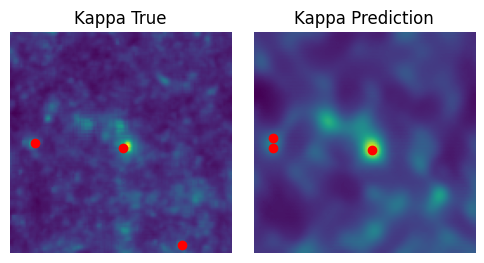

In [45]:
plot_kappa(true_kappa, prediction, show_dpeaks=True)

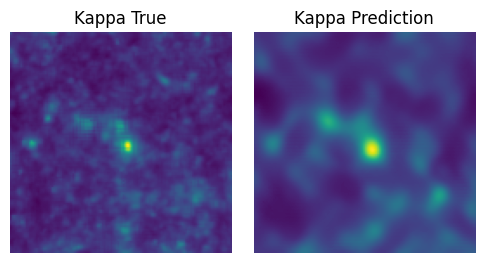

In [46]:
plot_kappa(true_kappa, prediction, show_dpeaks=False)

In [48]:
def compare_kappa(y_true, y_pred):
    plt.hist(y_true.flatten(), bins=100, alpha=0.6, label='True', color='blue', range=[-0.1, 0.5])
    plt.hist(y_pred.flatten(), bins=100, alpha=0.6, label='Pred', color='orange', range=[-0.1, 0.5])
    plt.legend(loc='upper right')
    plt.title('Histograma de Kappa')
    plt.xlabel('Kappa Value')
    plt.ylabel('Frequency')
    plt.show()

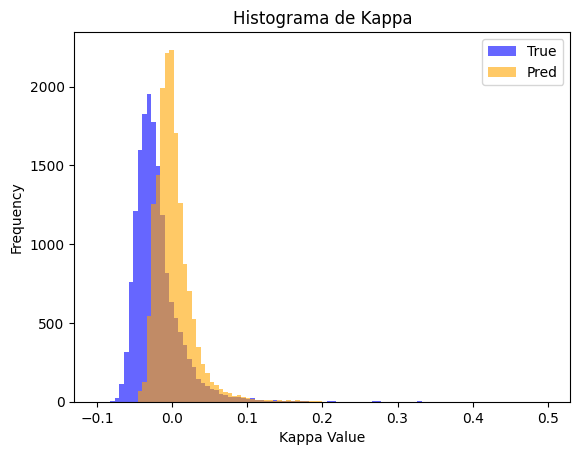

In [49]:
compare_kappa(true_kappa, prediction)

In [52]:
def compare_kappa_outlier(y_true, y_pred):
    plt.hist(y_true.flatten(), bins=100, alpha=0.6, label='True', color='blue', range=[0.1, 1])
    plt.hist(y_pred.flatten(), bins=100, alpha=0.6, label='Pred', color='orange', range=[0.1, 1])
    plt.legend(loc='upper right')
    plt.title('Histograma de Kappa')
    plt.xlabel('Kappa Value')
    plt.ylabel('Frequency')
    plt.show()

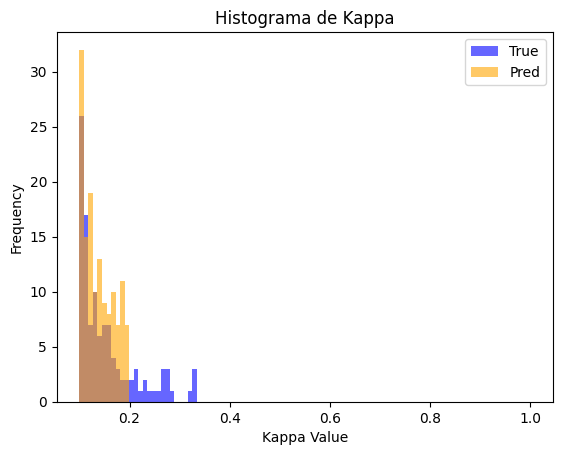

In [53]:
compare_kappa_outlier(true_kappa, prediction)

In [ ]:
def plot_scatter(y_true, y_pred):
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5, s=1)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Kappa')
    plt.ylabel('Predicted Kappa')
    plt.title('Scatter Plot of Predicted vs. True Kappa')
    plt.show()

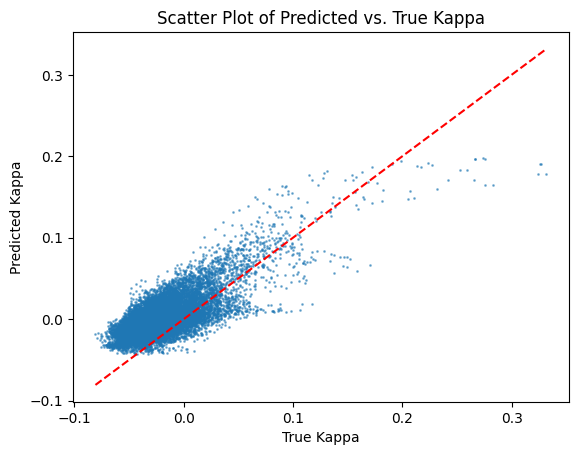

In [ ]:
plot_scatter(true_kappa, prediction)

In [ ]:
def plot_difference_map(y_true, y_pred):
    difference = y_true.squeeze() - y_pred.squeeze()
    plt.imshow(difference, cmap='RdBu', vmin=-difference.max(), vmax=difference.max())
    plt.colorbar(label='Difference')
    plt.title('Difference Map (True - Predicted)')
    plt.show()

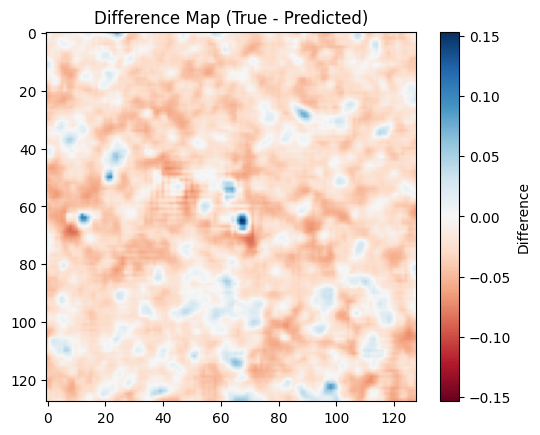

In [ ]:
plot_difference_map(true_kappa, prediction)

In [57]:
def plot_metric(metric, history):
    train_met = history['train_' + metric]
    val_met = history['val_' + metric]

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=np.arange(len(train_met)), y=train_met, mode='lines', name='Train'))
    fig.add_trace(go.Scatter(x=np.arange(len(val_met)), y=val_met, mode='lines', name='Validation'))

    fig.update_layout(title=f'{metric} Train vs Validation', xaxis_title='Epoch', yaxis_title=metric)

    fig.show()

In [58]:
checkpoint['history'].keys()

dict_keys(['train_losses', 'val_losses', 'train_wmape', 'val_wmape', 'train_dicee', 'val_dicee', 'train_dpeaks', 'val_dpeaks'])

In [59]:
metrics= ["dicee", "wmape", "dpeaks", "losses"]
history= checkpoint['history']
for met in metrics:
    plot_metric(met, history)